# Mini-project: Vocal Activity Detection

We will implement a vocal activity detection (VAD) system in this mini-project. VAD aims at detection speech and nonspeech regions in a given utterance, and it is an important module in many speech commnunication applications:
  - Assume that you are making a phone call, and your signal strength or network condition is bad. Typically, speech communication system encodes/compresses your voice into a compact representation, transmits it to the receiver, and deecodes/decompresses it back to your voice. Such transmission needs to be applied for both speech and non-speech regions. With VAD, the system does not need to transmit the non-speech or silent regions as they don't contain useful information. This can save the computation and network bandwidth.
  
A VAD module detects speech and non-speech regions through a classifier. The problem of VAD can be defined as a binary classification problem, where we assign a label "yes" or "no" to each short frame denoting whether it is a speech or non-speech frame. There are many ways that we can construct a classifier, and in this mini-project we will implement two methods: a support vector machine (SVM) classifier and a neural network classifier.

## 0. Data Preparation

Before we start building the models, let's first prepare the dataset for VAD and do some simple visualization.

The audio, adopted from https://github.com/jtkim-kaist/VAD, is a 15 minute clip recorded at a bus station by a cellphone.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import time

# load the audio file
audio, sr = sf.read('park.wav')

# visualize the audio
plt.plot(audio)
ticks_in_second = np.arange(len(audio)) / sr
max_second = np.floor(ticks_in_second[-1])
plt.xticks(ticks=np.arange(0, (max_second+1)*sr, (max_second+1)*sr/4), 
           labels=np.arange(0, (max_second+1), (max_second+1)/4))
plt.xlabel('Time (s)')
plt.tight_layout()

We can listen to part of it to get an intuition about what it sounds like:

In [2]:
from IPython.display import Audio
Audio(audio[sr*15:sr*25], rate=sr)

You can here wind noise, street noise, and people speaking. The task of VAD is to detect the regions where the people speak.

In this mini-project we will train and test our models in STFT domain. Let's calculate the magnitude spectrogram and the MFCC of this audio:

audio: (28864447,)
(257, 112752)
MEL min: 0.0
MEL max: 2840.023046708319
filter shape (64, 257)
minV 1e-08
min -640.0
(13, 112752)


/Users/alizare/opt/anaconda3/envs/envTF113/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in power


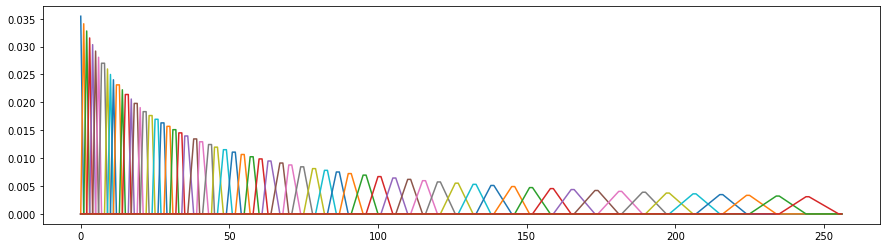

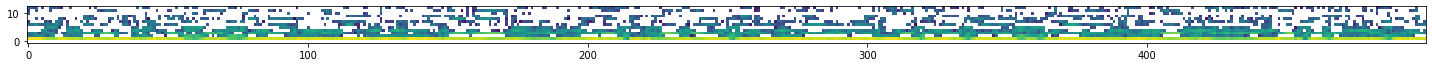

In [5]:
print('audio:', audio.shape)
audio_spec = librosa.stft(audio, n_fft=512, hop_length=256)
audio_spec_mag = np.abs(audio_spec)
print(audio_spec_mag.shape)
# TODO: calculate MFCC using the magnitude spectrogram above
# use 64 filters for Mel filterbank
# name your output as mel_spec

## reference: https://www.kaggle.com/ilyamich/mfcc-implementation-and-tutorial
freq_min = 0
freq_high = sr / 2
mel_filter_num=64
FFT_size=512
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sr)

def get_filters(filter_points, FFT_size):
    
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters
filters = get_filters(filter_points, FFT_size)


# taken from the librosa library This is being done to prevent the noise increase because if the increase of bandwidth
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])
    
print('filter shape', filters.shape)   
audio_filtered = np.dot(filters, (audio_spec_mag)**2)+1e-8
print('minV',np.amin(audio_filtered))
mel_logP = 10.0 * np.log10(audio_filtered)



def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

dct_filter_num = 26 # reduce the dimenssion from  filterbank=64 to 26 DCTs and then only keep 12 lower freqs

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, mel_logP)
mel_spec=cepstral_coefficents[:13, :]
print('min',np.amin(mel_spec))



print(mel_spec.shape)  # freq, time_steps

# visualize part of it
plt.figure(figsize=(20, 5))
plt.imshow(mel_spec[:,1500:2000]**.33, origin='lower')
plt.tight_layout()

Next we can load the frame-level labels for this audio clip. I've already processed the labels so that they match the length of the magnitude spectrogram above.

(112752,)


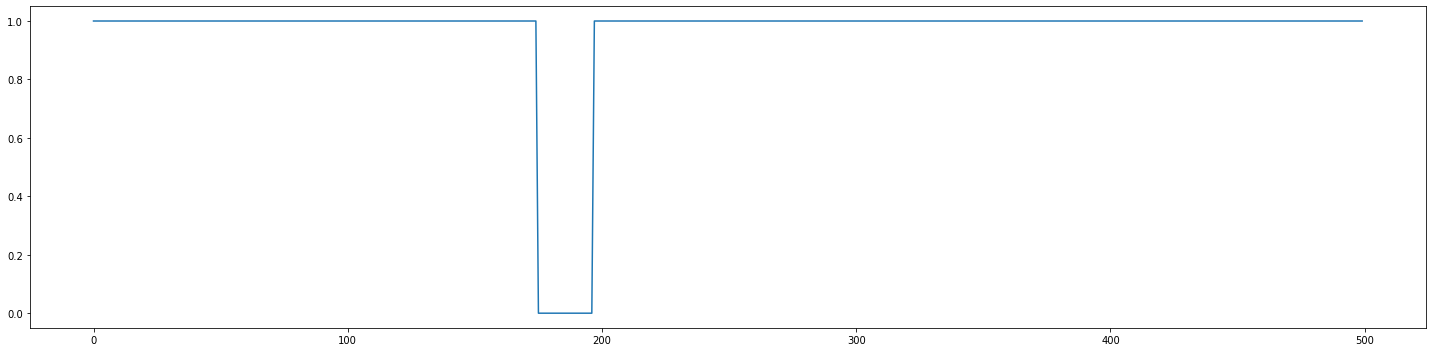

In [6]:
# load the label
label = np.asarray(np.load('audio_label.npy'))
print(label.shape)
# visualize part of it
plt.figure(figsize=(20, 5))
plt.plot(label[1500:2000])
plt.tight_layout()

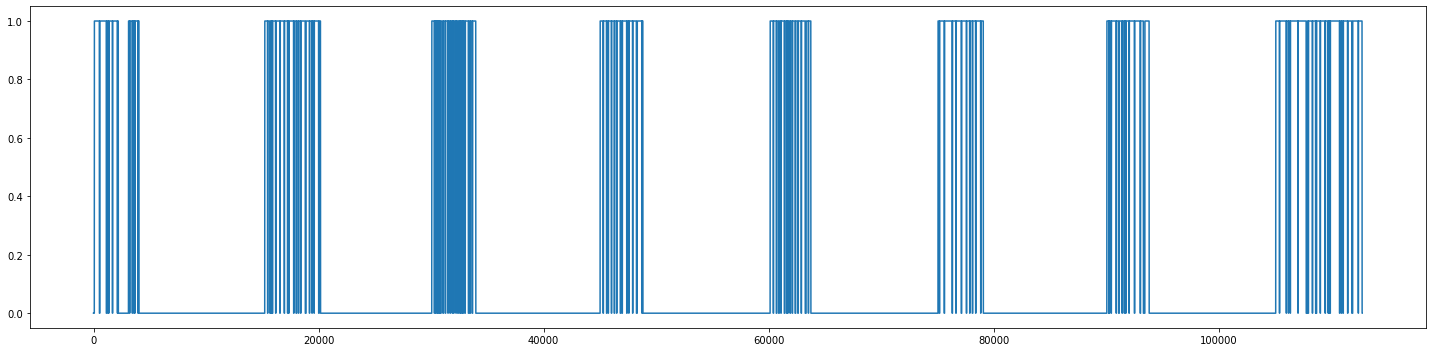

In [5]:
# visualize all of it
plt.figure(figsize=(20, 5))
plt.plot(label)
plt.tight_layout()

Here we will use the first 10000 frames for testing, 10000-20000 frames for validation, and the rest for training.

In [6]:
training_data = mel_spec[:,20000:]
validation_data = mel_spec[:,10000:20000]
test_data = mel_spec[:,:10000]

training_label = label[20000:]
validation_label = label[10000:20000]
test_label = label[:10000]

# MVN
training_mean = np.mean(training_data, 1)
training_var = np.var(training_data, 1)

training_data = (training_data - training_mean[:,np.newaxis]) / training_var[:,np.newaxis]
validation_data = (validation_data - training_mean[:,np.newaxis]) / training_var[:,np.newaxis]
test_data = (test_data - training_mean[:,np.newaxis]) / training_var[:,np.newaxis]

Now we are done with data preparation. Note that here we directly load all the data into the memory as the size of the data is pretty small. For large-scale dataset, you may still need to save the processed data to harddisk and load them with the *DataLoader* method in the Neural Network Basics homework.

## 1. Support Vector Machine

Determining whether a frame is speech or non-speech corresponds to a binary classification problem - we have two classes "speech" and "non-speech", and the model needs to make a prediction. 

Support vector machine (SVM) is a class of powerful classifiers before the dominance of neural networks, and is still one of the most important and widely-used tool nowadays. I will not go into the details of SVMs, and I just borrow a figure from [the Wikipedia page](https://en.wikipedia.org/wiki/Support_vector_machine) to show the intuition behind SVM:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/494px-SVM_margin.png">

As you can see, a linear SVM attempts to find a "line" ("hyperplane" in a high-dimensional space) that separates the two classes of features. It is generally used as a linear classifier, as it assumes that the features from different classes are **linearly separable**. 

When you train a SVM classifier, you fit the training dataset as well as the corresponding label to the classifier to learn the parameters (i.e. model weights). During test time, you only feed the test dataset into the model and the model makes predictions about the labels.

In this mini-project we will not ask you to implement a SVM classifier from scratch. Instead you are asked to use the [*sklearn* library](https://scikit-learn.org/stable/modules/svm.html) and train a SVM classifier with the data we prepared above.

We will use a linear SVM classifier, denoted by [*LinearSVC*](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) in th sklearn library, for this section. Click the link for *LinearSVC* for its usage, take a look at the examples provided, and apply it on our VAD data. You do not need to change any default parameters.

In [7]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
print('X', training_data.shape)
print('y', training_label.shape)

# TODO: use the LinearSVC class for the VAD data
# Set random_state to 0 and max_iter to 1e3 for a fair comparison

clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, max_iter=1e3))
clf.fit(training_data.T, training_label)

# TODO: make prediction on the training, validation, and test sets
# Also print the classification accuracy
trn_pred=clf.predict(training_data.T)
trn_acs=clf.score(training_data.T, training_label)

vld_pred=clf.predict(validation_data.T)
vld_acs=clf.score(validation_data.T, validation_label)

tst_pred=clf.predict(test_data.T)
tst_acs=clf.score(test_data.T, test_label)

print('mean accuracy of training prediction:', trn_acs)

print('mean accuracy of validation prediction:', vld_acs)
print('mean accuracy of test prediction:', tst_acs)

X (13, 92752)
y (92752,)
mean accuracy of training prediction: 0.9135652061411075
mean accuracy of validation prediction: 0.8661
mean accuracy of test prediction: 0.8441


/Users/alizare/opt/anaconda3/envs/envTF113/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear SVM requires that the features are linearly separable. However, this is hardly the case for most of the tasks. No worries - for features that are not linearly separable, we can try to find a transformed representation of the features so that the transformed features are linearly separable in another feature space. In SVM, this is called the **kernel trick**, where the kernel can be a nonlinear mapping applied to the features that transforms them to another representation space. This gives us a nonlinear SVM classifier. We will not go into the details of the kernel tricks in SVM in this mini-project.

As a final step, visualize the predictions from the Linear-SVM and compare with the target labels. What do you find?

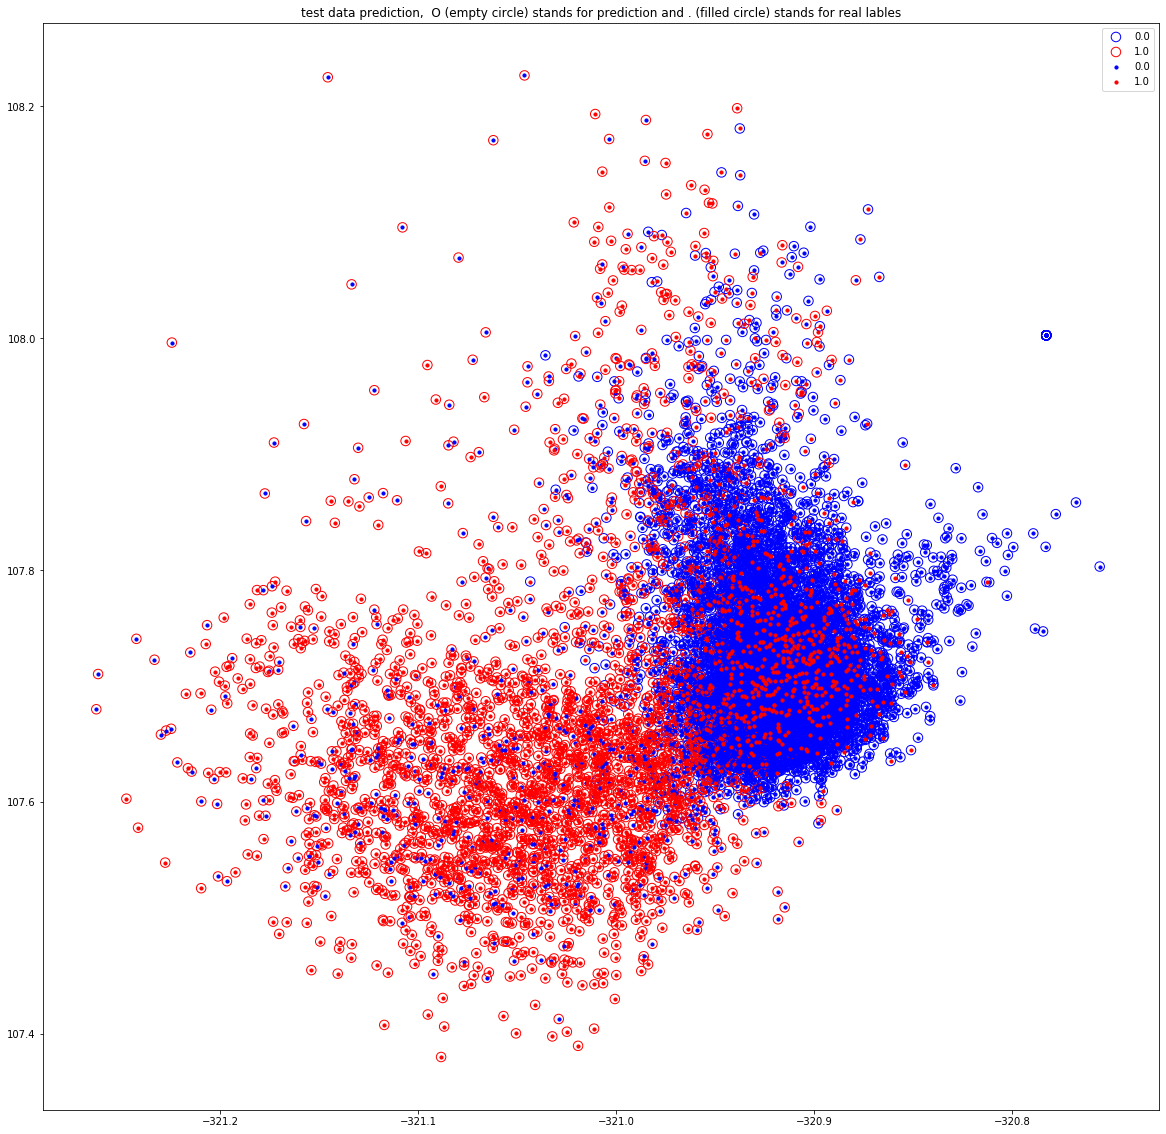

In [8]:
# TODO: visualize the predictions by Linear-SV and compare with target label

# we use PCA for dimenssion reduction to 2d. 
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2)
XX=mel_spec.T
X=pca.fit_transform(XX)

rdTrn=pca.transform(training_data.T)
rdVld=pca.transform(validation_data.T)
rdTst=pca.transform(test_data.T)

data = pd.DataFrame({"X Value": rdTst[:, 0], "Y Value": rdTst[:, 1], "Category": tst_pred, "rel_L": test_label})
groups = data.groupby("Category")
plt.figure(figsize=(20,20))
for name, group in groups:
    if name==1:
        mycolor='r'
    else:
        mycolor='b'

    plt.scatter(group["X Value"], group["Y Value"],facecolors='none', edgecolors=mycolor, s=90, label=name)
plt.legend()

groups = data.groupby("rel_L")
for name, group in groups:
    if name==1:
        mycolor='r'
    else:
        mycolor='b'

    plt.scatter(group["X Value"], group["Y Value"],facecolors=mycolor, edgecolors=mycolor, s=10, label=name)
plt.legend()
plt.title( 'test data prediction,  O (empty circle) stands for prediction and . (filled circle) stands for real lables')

    


plt.show()



## 2. Neural Network Classifier

Now we build a simple neural network classifier. We wil use the 3-layer MLP in the Neural Network Basics homework for the classifier. The MLP we discussed in the previous homework is for the task of autoencoding, but here we need to perform a biinary classification task. As a result, we need to change both the input and output dimensions of the model.

The input dimension here is the dimension of the MFCC features (remember that MLP processes each frame independently). Since we are doing a binary classification, the output dimension can thus be 1, representing the **probability** that the input frame belongs to speech or non-speech region. We use *Sigmoid function* to ensure that the range of the output meets the requirement of a probability measure, i.e. between 0 and 1.

Implement the MLP below.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# TODO: adopt the 3-layer MLP from the Neural Network Basics homework here
# Remember to modify the input/output dimensions
print(mel_spec.shape)
class MLP(nn.Module):
    def __init__(self, feature_dim):
        super(MLP, self).__init__()
        
        # layers, and activation function
        
        self.feature_dim = feature_dim
        self.hidden_unit = 12  # number of hidden units
        
        # input layer
        # nn.Sequential allows you to wrap multiple layers into a single large layer
        # all the layers inside an nn.Sequential object will run in their sequential order
        self.layer1 = nn.Sequential(nn.Linear(self.feature_dim, self.hidden_unit),
                                    nn.Sigmoid()
                                   )
        
        # do the same for two other layers
        # hidden layer
        self.layer2 = nn.Sequential(nn.Linear(self.hidden_unit, self.hidden_unit),
                                    nn.Sigmoid()
                                   )
        self.layer3 = nn.Sequential(nn.Linear(self.hidden_unit, self.hidden_unit),
                                    nn.Sigmoid()
                                   )
        
        # output layer
        # here we do not apply a nonlinear activation function as we want to do autoencoding
        self.layer4 = nn.Sequential(nn.Linear(self.hidden_unit, 1),
                                    nn.Sigmoid()
                                   )
        
    # the function for the forward pass of network (i.e. from input to output)
    def forward(self, input):
        # the input is a batch of spectrograms with shape (batch_size, frequency_dim, time_step)
        # we want the MLP to be applied to the frequency_dim dimension, i.e. process each frame independently
        # we need to rotate the last two dimensions and reshape it into a 2-D matrix with shape (batch_size*time_step, frequency_dim)
        batch_size, freq_dim, time_step = input.shape
        print('batch_size, freq_dim, time_step',batch_size, freq_dim, time_step)
        
        input = input.transpose(1, 2).contiguous()  # (batch, time, freq), swap the two dimensions
        input = input.view(batch_size*time_step, freq_dim)  # (batch*time, freq), reshaping
        
        # pass it through the three layers
        output = self.layer1(input)  # (batch*time, hidden_unit)
        output = self.layer2(output)  # (batch*time, hidden_unit)
        #output = self.layer3(output)  # (batch*time, freq)
        output = self.layer4(output)
        
        # reshape back
        output = output.view(batch_size, time_step, 1)  # (batch, time, freq)
        output = output.transpose(1, 2).contiguous()  # (batch, freq, time), swap the two dimension back
        output=torch.squeeze(output)
        return output

# test if the model works well
model_MLP = MLP(feature_dim=mel_spec.shape[0])

input = torch.randn((2, mel_spec.shape[0], 40))
output = model_MLP(input)

print("Shape of input:", tuple(input.data.shape))
print("Shape of output:", tuple(output.data.shape))
# TODO: initialize the optimizer here
# you can still use Adam as the optimizer

optimizer = optim.Adam(model_MLP.parameters(), lr=1e-3)

(13, 112752)
batch_size, freq_dim, time_step 2 13 40
Shape of input: (2, 13, 40)
Shape of output: (2, 40)


In the autoencoding task we used the mean-square error (MSE) as the training objective. For classification tasks, we typically use **cross-entropy (CE)** as the training objective. CE denotes how close two distributions are, and it is always nonnegative - lower values of CE means higher similarities of the two distributions. In our case where the target is either 0 or 1, i.e. the binary classification task, the loss is called the [**binary cross-entropy (BCE)** loss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a):
<img src="https://miro.medium.com/max/1096/1*rdBw0E-My8Gu3f_BOB6GMA.png">

Here **y** is the label (0 or 1), **p(y)** is the predicted probability (between 0 and 1), and **N** is the total number of training samples you have in a batch. The closer **p(y)** is to **y**, the lower value the loss function will get.

Implement the BCE function in Pytorch. Note that Pytorch does have a built-in function for BCE, but you should not use it directly here.


In [20]:
# TODO: implement BCE function

def BCE(prediction, label):
    """
    BCE between the predicted probabilities and the target labels.
    args:
        prediction: shape (num_frame,), torch tensor
        label: shape (num_frame,), torch tensor
    output:
        BCE_value: float, a single value
    """
    #print(prediction)
    batch_size = prediction.shape[0]
    if batch_size==1:
        T2=(1-label)*(torch.log2(1-prediction+1e-8))
        T1=label*torch.log2(prediction+1e-8)
        BCE_value = -1*(T1+T2).mean()
    else:
        T2=(1-label)*(torch.log2(1-prediction+1e-8))
        T1=label*torch.log2(prediction+1e-8)
        BCE_value = -1*(T1+T2).mean(1)   
    
    
    return BCE_value


Remember that during the training phase of the MLP, we evaluate the model performance on the validation set to select the best model. However, knowing the value of BCE does not mean that we know the actual classification accuracy. Thus we also need another function to calculate the accuracy given the predicted probabilities.

Typically we use a simple threshold-based rule to determine the predicted label from the predicted probability: if the predicted probabiliti is higher than 0.5, then we categorize it into label 1, otherwise we categorize it to label 0. We can then compare the predicted label with the target label to calculate the accuracy.

Implement this accuracy calculation function.

In [21]:
# TODO: implement accuracy calculation function

def Accuracy(prediction, label):
    """
    BCE between the predicted probabilities and the target labels.
    args:
        prediction: shape (num_frame,), torch tensor
        label: shape (num_frame,), torch tensor
    output:
        acc_value: float, a single value, a percentage value between 0 and 100 (corresponds to 0% and 100% accuracy)
    """
    batch_size = prediction.shape[0]
    if batch_size==1:
        pred=1.0*(prediction>0.5)
        acc_value= 1.0*(pred==label)
        acc_value=acc_value.mean()*100
    else:
        pred=1.0*(prediction>0.5)
        acc_value= 1.0*(pred==label)
        acc_value=acc_value.mean(1)*100
            
    return acc_value




Now train the MLP model with the training pipeline we used in the previous homework. Use BCE function for training, and Accuracy for validation to select the best model. 

Also note that the accuracy should be calculated on the entire validation set (10000 frames), so you should feed all the 10000 frames into the Accuracy function to get the correct value. You need to achieve over 85% accuracy on the validation set to get the full marks here, so play with the configurations of the MLP - nonlinearity in the hidden layers, number of hidden units, number of layers, learning rate, or any other tricks you know. Try to hit the highest accuracy you can achieve!

You may also encounter NaNs during training. Think about why and how you can avoid it.

In [22]:
print(training_data.shape[1]/16)

5797.0


In [23]:
import h5py
print(training_label.shape)
tr_name = 'tr_set3.hdf5'
val_name = 'val_set3.hdf5'
test_name = 'test_set3.hdf5'

tr_dataset = h5py.File(tr_name, 'a')
val_dataset = h5py.File(val_name, 'a')
test_dataset = h5py.File(test_name, 'a')
batch_size = 16

def make_batch(a, batch_size):
    b=a.reshape(a.shape[0],batch_size,a.shape[1]//batch_size).transpose(1,0,2)
    return b

for i in range(batch_size):

    if i == 0:
        # create sub-datasets
        tr_dataset.create_dataset('label', shape=(batch_size,training_label.shape[0]//batch_size), dtype=np.float32)
        tr_dataset.create_dataset('mfcc', shape=(batch_size, training_data.shape[0],training_data.shape[1]//batch_size )
                                  , dtype=np.float32)

    tr_dataset['label'][i] = training_label.reshape(batch_size,-1)[i,:]
    tr_dataset['mfcc'][i] = make_batch(training_data,batch_size)[i,:,:]

for i in range(batch_size):

    if i == 0:
        # create sub-datasets
        val_dataset.create_dataset('label', shape=(batch_size,validation_label.shape[0]//batch_size), dtype=np.float32)
        val_dataset.create_dataset('mfcc', shape=(batch_size, validation_data.shape[0],validation_data.shape[1]//batch_size )
                                  , dtype=np.float32)

    val_dataset['label'][i] = validation_label.reshape(batch_size,-1)[i,:]
    val_dataset['mfcc'][i] = make_batch(validation_data,batch_size)[i,:,:]
    
for i in range(batch_size):

    if i == 0:
        # create sub-datasets
        test_dataset.create_dataset('label', shape=(batch_size,test_label.shape[0]//batch_size), dtype=np.float32)
        test_dataset.create_dataset('mfcc', shape=(batch_size, test_data.shape[0],test_data.shape[1]//batch_size )
                                  , dtype=np.float32)

    test_dataset['label'][i] = test_label.reshape(batch_size,-1)[i,:]
    test_dataset['mfcc'][i] = make_batch(test_data,batch_size)[i,:,:]
    
tr_dataset.close()
val_dataset.close()
test_dataset.close()

(92752,)


RuntimeError: Unable to create link (name already exists)

In [24]:
a=np.arange(24).reshape(4,-1)
print(a)
b=a.reshape(4,3,6//3).transpose(1,0,2)
print(b.shape, b[1,:,:])

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]]
(3, 4, 2) [[ 2  3]
 [ 8  9]
 [14 15]
 [20 21]]


In [25]:
from torch.utils.data import Dataset, DataLoader

# TODO: implement DataLoaders that delivers the MFCC feature and the target label to the networks
# You can either save all the data via h5py, or directly load them in the memory
# How can you modify the data loading functions in the previous homework?




    
# TODO: define data loaders for training, validation, and test

batch_size = 32



class dataset_pipeline(Dataset):
    def __init__(self, path):
        super(dataset_pipeline, self).__init__()

        self.h5pyLoader = h5py.File(path, 'r')
        
        self.spec = self.h5pyLoader['mfcc']
        self.label = self.h5pyLoader['label']
        
        self._len = self.spec.shape[0]  # number of utterances
    
    def __getitem__(self, index):
        spec_item = torch.from_numpy(self.spec[index].astype(np.float32))
        label_item = torch.from_numpy(self.label[index].astype(np.float32))
            
        return spec_item, label_item
    
    def __len__(self):
        return self._len
    
# define data loaders
train_loader = DataLoader(dataset_pipeline('tr_set3.hdf5'), 
                          batch_size=batch_size, 
                          shuffle=True,  # this ensures that the sequential order of the training samples will be shuffled for different training epochs
                         )

validation_loader = DataLoader(dataset_pipeline('val_set2.hdf5'), 
                               batch_size=batch_size, 
                               shuffle=False,  # typically we fix the sequential order of the validation samples
                              )

test_loader = DataLoader(dataset_pipeline('test_set2.hdf5'), 
                               batch_size=batch_size, 
                               shuffle=False,  # typically we fix the sequential order of the validation samples
                              )


dataset_len = len(train_loader)
log_step = dataset_len // 4 +1
print(dataset_len)

1


In [26]:
# TODO: functions for training and validation
# Use BCE during training, and Accuracy during validation

def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()  # set the model to training mode. Always do this before you start training!
    train_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(train_loader):
        batch_spec = data[0]
        batch_label= data[1]
        
        # clean up the gradients in the optimizer
        # this should be called for each batch
        optimizer.zero_grad()
        
        output = model(batch_spec)
        #print('o', output.shape)
        # MSE as objective
        #print('l',batch_label.shape)
        loss = BCE(output, batch_label)
        
        # automatically calculate the backward pass
        loss.sum().backward()
        # perform the actual backpropagation
        optimizer.step()
        
        train_loss += loss.sum().data.item()
        
        # OPTIONAL: you can print the training progress 
        if versatile:
            if (batch_idx+1) % log_step == 0:
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | BCE {:5.4f} |'.format(
                    epoch, batch_idx+1, len(train_loader),
                    elapsed * 1000 / (batch_idx+1), 
                    train_loss / (batch_idx+1)
                    ))
    
    train_loss /= (batch_idx+1)
    print('-' * 99)
    print('    | end of training epoch {:3d} | time: {:5.2f}s | BCE {:5.4f} |'.format(
            epoch, (time.time() - start_time), train_loss))
    
    return train_loss
        
def validate(model, epoch):
    start_time = time.time()
    model = model.eval()  # set the model to evaluation mode. Always do this during validation or test phase!
    validation_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(validation_loader):
        batch_spec = data[0]
        batch_label= data[1]
        
        # you don't need to calculate the backward pass and the gradients during validation
        # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
        with torch.no_grad():
        
            output = model(batch_spec)
        
            # MSE as objective
            loss = Accuracy(output,batch_label )
        
            validation_loss += loss.data.item()
    
    validation_loss /= (batch_idx+1)
    print('    | end of validation epoch {:3d} | time: {:5.2f}s | accs {:5.4f} |'.format(
            epoch, (time.time() - start_time), validation_loss))
    print('-' * 99)
    
    return validation_loss

In [27]:
# hyperparameters

total_epoch = 4000  # train the model for 100 epochs
model_save = 'best_MLP_VAD.pt'  # path to save the best validation model

# main function

training_loss = []
validation_acc = []

for epoch in range(1, total_epoch + 1):
    training_loss.append(train(model_MLP, epoch))
    validation_acc.append(validate(model_MLP, epoch))
    
    if training_loss[-1] == np.min(training_loss):
        print('      Best training model found.')
    if validation_acc[-1] == np.max(validation_acc):
        # save current best model on validation set
        with open(model_save, 'wb') as f:
            torch.save(model_MLP.state_dict(), f)
            print('      Best validation model found and saved.')
    
    print('-' * 99)

batch_size, freq_dim, time_step 16 13 5797
| epoch   1 |     1/    1 batches | ms/batch 44.28 | BCE 16.9474 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  0.04s | BCE 16.9474 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch   1 | time:  0.00s | accs 41.9900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch   2 |     1/    1 batches | ms/batch 43.99 | BCE 16.8829 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   2 | time:  0.04s | BCE 16.8829 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch  14 |     1/    1 batches | ms/batch 39.85 | BCE 16.1532 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  14 | time:  0.04s | BCE 16.1532 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch  14 | time:  0.00s | accs 41.9900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch  15 |     1/    1 batches | ms/batch 40.08 | BCE 16.0963 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  15 | time:  0.04s | BCE 16.0963 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch  15 | time:  0.00s | accs 41.9700 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch  29 |     1/    1 batches | ms/batch 40.43 | BCE 15.3675 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  29 | time:  0.04s | BCE 15.3675 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch  29 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch  30 |     1/    1 batches | ms/batch 39.83 | BCE 15.3204 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  30 | time:  0.04s | BCE 15.3204 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

batch_size, freq_dim, time_step 16 13 5797
| epoch  43 |     1/    1 batches | ms/batch 41.77 | BCE 14.7665 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  43 | time:  0.04s | BCE 14.7665 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch  43 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch  44 |     1/    1 batches | ms/batch 41.21 | BCE 14.7283 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  44 | time:  0.04s | BCE 14.7283 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch  56 |     1/    1 batches | ms/batch 41.31 | BCE 14.3162 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  56 | time:  0.04s | BCE 14.3162 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch  56 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch  57 |     1/    1 batches | ms/batch 40.48 | BCE 14.2856 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  57 | time:  0.04s | BCE 14.2856 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch  57 | time:  0.00s | accs 58.0100 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch  70 |     1/    1 batches | ms/batch 41.36 | BCE 13.9352 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  70 | time:  0.04s | BCE 13.9352 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch  70 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch  71 |     1/    1 batches | ms/batch 40.80 | BCE 13.9117 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  71 | time:  0.04s | BCE 13.9117 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch  84 |     1/    1 batches | ms/batch 39.66 | BCE 13.6475 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  84 | time:  0.04s | BCE 13.6475 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch  84 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch  85 |     1/    1 batches | ms/batch 40.11 | BCE 13.6301 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  85 | time:  0.04s | BCE 13.6301 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch  85 | time:  0.00s | accs 58.0100 |
-

| epoch  98 |     1/    1 batches | ms/batch 42.13 | BCE 13.4375 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  98 | time:  0.04s | BCE 13.4375 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch  98 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch  99 |     1/    1 batches | ms/batch 41.35 | BCE 13.4250 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  99 | time:  0.04s | BCE 13.4250 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch  99 | time:  0.00s | accs 58.0100 |
-

| epoch 111 |     1/    1 batches | ms/batch 48.90 | BCE 13.2980 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 111 | time:  0.05s | BCE 13.2980 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 111 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 112 |     1/    1 batches | ms/batch 41.19 | BCE 13.2892 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 112 | time:  0.04s | BCE 13.2892 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 112 | time:  0.00s | accs 58.0100 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 125 |     1/    1 batches | ms/batch 43.73 | BCE 13.1936 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 125 | time:  0.04s | BCE 13.1936 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 125 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 126 |     1/    1 batches | ms/batch 41.66 | BCE 13.1876 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 126 | time:  0.04s | BCE 13.1876 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch 138 |     1/    1 batches | ms/batch 38.95 | BCE 13.1277 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 138 | time:  0.04s | BCE 13.1277 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 138 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 139 |     1/    1 batches | ms/batch 40.10 | BCE 13.1236 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 139 | time:  0.04s | BCE 13.1236 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 139 | time:  0.00s | accs 58.0100 |
-

| epoch 152 |     1/    1 batches | ms/batch 41.28 | BCE 13.0798 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 152 | time:  0.04s | BCE 13.0798 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 152 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 153 |     1/    1 batches | ms/batch 41.71 | BCE 13.0771 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 153 | time:  0.04s | BCE 13.0771 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 153 | time:  0.00s | accs 58.0100 |
-

      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 166 |     1/    1 batches | ms/batch 44.87 | BCE 13.0476 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 166 | time:  0.05s | BCE 13.0476 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 166 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 167 |     1/    1 batches | ms/batch 44.13 | BCE 13.0458 |
-------------------------------------------------------------------------------------

batch_size, freq_dim, time_step 16 13 5797
| epoch 183 |     1/    1 batches | ms/batch 43.03 | BCE 13.0212 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 183 | time:  0.04s | BCE 13.0212 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 183 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 184 |     1/    1 batches | ms/batch 41.07 | BCE 13.0200 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 184 | time:  0.04s | BCE 13.0200 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch 196 |     1/    1 batches | ms/batch 43.05 | BCE 13.0064 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 196 | time:  0.04s | BCE 13.0064 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 196 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 197 |     1/    1 batches | ms/batch 41.77 | BCE 13.0053 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 197 | time:  0.04s | BCE 13.0053 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 197 | time:  0.00s | accs 58.0100 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 210 |     1/    1 batches | ms/batch 43.62 | BCE 12.9931 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 210 | time:  0.04s | BCE 12.9931 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 210 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 211 |     1/    1 batches | ms/batch 41.08 | BCE 12.9922 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 211 | time:  0.04s | BCE 12.9922 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch 223 |     1/    1 batches | ms/batch 40.85 | BCE 12.9821 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 223 | time:  0.04s | BCE 12.9821 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 223 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 224 |     1/    1 batches | ms/batch 41.96 | BCE 12.9813 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 224 | time:  0.04s | BCE 12.9813 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 224 | time:  0.00s | accs 58.0100 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 237 |     1/    1 batches | ms/batch 44.21 | BCE 12.9710 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 237 | time:  0.04s | BCE 12.9710 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 237 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 238 |     1/    1 batches | ms/batch 41.16 | BCE 12.9702 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 238 | time:  0.04s | BCE 12.9702 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch 250 |     1/    1 batches | ms/batch 42.30 | BCE 12.9610 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 250 | time:  0.04s | BCE 12.9610 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 250 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 251 |     1/    1 batches | ms/batch 42.07 | BCE 12.9602 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 251 | time:  0.04s | BCE 12.9602 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 251 | time:  0.00s | accs 58.0100 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 264 |     1/    1 batches | ms/batch 44.57 | BCE 12.9502 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 264 | time:  0.04s | BCE 12.9502 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 264 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 265 |     1/    1 batches | ms/batch 40.27 | BCE 12.9494 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 265 | time:  0.04s | BCE 12.9494 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch 277 |     1/    1 batches | ms/batch 42.24 | BCE 12.9401 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 277 | time:  0.04s | BCE 12.9401 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 277 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 278 |     1/    1 batches | ms/batch 44.44 | BCE 12.9393 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 278 | time:  0.04s | BCE 12.9393 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 278 | time:  0.00s | accs 58.0100 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 291 |     1/    1 batches | ms/batch 43.60 | BCE 12.9290 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 291 | time:  0.04s | BCE 12.9290 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 291 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 292 |     1/    1 batches | ms/batch 40.52 | BCE 12.9282 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 292 | time:  0.04s | BCE 12.9282 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch 304 |     1/    1 batches | ms/batch 41.63 | BCE 12.9185 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 304 | time:  0.04s | BCE 12.9185 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 304 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 305 |     1/    1 batches | ms/batch 42.39 | BCE 12.9176 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 305 | time:  0.04s | BCE 12.9176 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 305 | time:  0.00s | accs 58.0100 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 318 |     1/    1 batches | ms/batch 43.31 | BCE 12.9069 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 318 | time:  0.04s | BCE 12.9069 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 318 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 319 |     1/    1 batches | ms/batch 41.89 | BCE 12.9060 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 319 | time:  0.04s | BCE 12.9060 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch 331 |     1/    1 batches | ms/batch 42.10 | BCE 12.8958 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 331 | time:  0.04s | BCE 12.8958 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 331 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 332 |     1/    1 batches | ms/batch 40.93 | BCE 12.8949 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 332 | time:  0.04s | BCE 12.8949 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 332 | time:  0.00s | accs 58.0100 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 345 |     1/    1 batches | ms/batch 43.34 | BCE 12.8835 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 345 | time:  0.04s | BCE 12.8835 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 345 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 346 |     1/    1 batches | ms/batch 41.84 | BCE 12.8826 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 346 | time:  0.04s | BCE 12.8826 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch 358 |     1/    1 batches | ms/batch 41.95 | BCE 12.8717 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 358 | time:  0.04s | BCE 12.8717 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 358 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 359 |     1/    1 batches | ms/batch 41.88 | BCE 12.8708 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 359 | time:  0.04s | BCE 12.8708 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 359 | time:  0.00s | accs 58.0100 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 372 |     1/    1 batches | ms/batch 43.88 | BCE 12.8587 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 372 | time:  0.04s | BCE 12.8587 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 372 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 373 |     1/    1 batches | ms/batch 43.54 | BCE 12.8577 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 373 | time:  0.04s | BCE 12.8577 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch 385 |     1/    1 batches | ms/batch 42.37 | BCE 12.8461 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 385 | time:  0.04s | BCE 12.8461 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 385 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 386 |     1/    1 batches | ms/batch 43.04 | BCE 12.8451 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 386 | time:  0.04s | BCE 12.8451 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 386 | time:  0.00s | accs 58.0100 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 399 |     1/    1 batches | ms/batch 42.73 | BCE 12.8321 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 399 | time:  0.04s | BCE 12.8321 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 399 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 400 |     1/    1 batches | ms/batch 40.77 | BCE 12.8311 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 400 | time:  0.04s | BCE 12.8311 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch 412 |     1/    1 batches | ms/batch 42.36 | BCE 12.8186 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 412 | time:  0.04s | BCE 12.8186 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 412 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 413 |     1/    1 batches | ms/batch 42.67 | BCE 12.8176 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 413 | time:  0.04s | BCE 12.8176 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 413 | time:  0.00s | accs 58.0100 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 426 |     1/    1 batches | ms/batch 44.02 | BCE 12.8036 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 426 | time:  0.04s | BCE 12.8036 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 426 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 427 |     1/    1 batches | ms/batch 42.31 | BCE 12.8025 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 427 | time:  0.04s | BCE 12.8025 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch 439 |     1/    1 batches | ms/batch 42.56 | BCE 12.7891 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 439 | time:  0.04s | BCE 12.7891 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 439 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 440 |     1/    1 batches | ms/batch 41.83 | BCE 12.7879 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 440 | time:  0.04s | BCE 12.7879 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 440 | time:  0.00s | accs 58.0100 |
-

    | end of validation epoch 452 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 453 |     1/    1 batches | ms/batch 45.07 | BCE 12.7729 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 453 | time:  0.05s | BCE 12.7729 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 453 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
------------------------------------------------------------------------------------------------

| epoch 465 |     1/    1 batches | ms/batch 44.49 | BCE 12.7585 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 465 | time:  0.04s | BCE 12.7585 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 465 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 466 |     1/    1 batches | ms/batch 45.07 | BCE 12.7572 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 466 | time:  0.05s | BCE 12.7572 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 466 | time:  0.00s | accs 58.0100 |
-

| epoch 481 |     1/    1 batches | ms/batch 43.96 | BCE 12.7385 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 481 | time:  0.04s | BCE 12.7385 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 481 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 482 |     1/    1 batches | ms/batch 46.03 | BCE 12.7372 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 482 | time:  0.05s | BCE 12.7372 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 482 | time:  0.00s | accs 58.0100 |
-

| epoch 497 |     1/    1 batches | ms/batch 45.52 | BCE 12.7176 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 497 | time:  0.05s | BCE 12.7176 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 497 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 498 |     1/    1 batches | ms/batch 47.51 | BCE 12.7162 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 498 | time:  0.05s | BCE 12.7162 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 498 | time:  0.00s | accs 58.0100 |
-

| epoch 513 |     1/    1 batches | ms/batch 47.77 | BCE 12.6957 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 513 | time:  0.05s | BCE 12.6957 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 513 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 514 |     1/    1 batches | ms/batch 48.02 | BCE 12.6943 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 514 | time:  0.05s | BCE 12.6943 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 514 | time:  0.00s | accs 58.0100 |
-

| epoch 529 |     1/    1 batches | ms/batch 47.66 | BCE 12.6727 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 529 | time:  0.05s | BCE 12.6727 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 529 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 530 |     1/    1 batches | ms/batch 47.96 | BCE 12.6713 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 530 | time:  0.05s | BCE 12.6713 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 530 | time:  0.00s | accs 58.0100 |
-

| epoch 545 |     1/    1 batches | ms/batch 47.49 | BCE 12.6487 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 545 | time:  0.05s | BCE 12.6487 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 545 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 546 |     1/    1 batches | ms/batch 50.79 | BCE 12.6471 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 546 | time:  0.05s | BCE 12.6471 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 546 | time:  0.00s | accs 58.0100 |
-

| epoch 561 |     1/    1 batches | ms/batch 48.18 | BCE 12.6234 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 561 | time:  0.05s | BCE 12.6234 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 561 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 562 |     1/    1 batches | ms/batch 51.16 | BCE 12.6218 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 562 | time:  0.05s | BCE 12.6218 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 562 | time:  0.00s | accs 58.0100 |
-

| epoch 577 |     1/    1 batches | ms/batch 48.75 | BCE 12.5969 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 577 | time:  0.05s | BCE 12.5969 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 577 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 578 |     1/    1 batches | ms/batch 48.94 | BCE 12.5952 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 578 | time:  0.05s | BCE 12.5952 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 578 | time:  0.00s | accs 58.0100 |
-

| epoch 593 |     1/    1 batches | ms/batch 48.36 | BCE 12.5691 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 593 | time:  0.05s | BCE 12.5691 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 593 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 594 |     1/    1 batches | ms/batch 49.17 | BCE 12.5674 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 594 | time:  0.05s | BCE 12.5674 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 594 | time:  0.00s | accs 58.0100 |
-

| epoch 609 |     1/    1 batches | ms/batch 48.54 | BCE 12.5399 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 609 | time:  0.05s | BCE 12.5399 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 609 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 610 |     1/    1 batches | ms/batch 49.66 | BCE 12.5380 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 610 | time:  0.05s | BCE 12.5380 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 610 | time:  0.00s | accs 58.0100 |
-

| epoch 625 |     1/    1 batches | ms/batch 48.84 | BCE 12.5092 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 625 | time:  0.05s | BCE 12.5092 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 625 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 626 |     1/    1 batches | ms/batch 50.89 | BCE 12.5072 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 626 | time:  0.05s | BCE 12.5072 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 626 | time:  0.00s | accs 58.0100 |
-

| epoch 641 |     1/    1 batches | ms/batch 49.13 | BCE 12.4769 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 641 | time:  0.05s | BCE 12.4769 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 641 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 642 |     1/    1 batches | ms/batch 49.65 | BCE 12.4749 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 642 | time:  0.05s | BCE 12.4749 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 642 | time:  0.00s | accs 58.0100 |
-

| epoch 657 |     1/    1 batches | ms/batch 49.16 | BCE 12.4430 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 657 | time:  0.05s | BCE 12.4430 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 657 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 658 |     1/    1 batches | ms/batch 49.18 | BCE 12.4408 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 658 | time:  0.05s | BCE 12.4408 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 658 | time:  0.00s | accs 58.0100 |
-

| epoch 673 |     1/    1 batches | ms/batch 51.71 | BCE 12.4072 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 673 | time:  0.05s | BCE 12.4072 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 673 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 674 |     1/    1 batches | ms/batch 48.69 | BCE 12.4049 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 674 | time:  0.05s | BCE 12.4049 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 674 | time:  0.00s | accs 58.0100 |
-

| epoch 689 |     1/    1 batches | ms/batch 50.63 | BCE 12.3696 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 689 | time:  0.05s | BCE 12.3696 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 689 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 690 |     1/    1 batches | ms/batch 50.09 | BCE 12.3672 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 690 | time:  0.05s | BCE 12.3672 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 690 | time:  0.00s | accs 58.0100 |
-

| epoch 705 |     1/    1 batches | ms/batch 50.74 | BCE 12.3300 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 705 | time:  0.05s | BCE 12.3300 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 705 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 706 |     1/    1 batches | ms/batch 50.26 | BCE 12.3274 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 706 | time:  0.05s | BCE 12.3274 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 706 | time:  0.00s | accs 58.0100 |
-

| epoch 720 |     1/    1 batches | ms/batch 51.39 | BCE 12.2909 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 720 | time:  0.05s | BCE 12.2909 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 720 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 721 |     1/    1 batches | ms/batch 50.01 | BCE 12.2883 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 721 | time:  0.05s | BCE 12.2883 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 721 | time:  0.00s | accs 58.0100 |
-

| epoch 736 |     1/    1 batches | ms/batch 50.15 | BCE 12.2472 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 736 | time:  0.05s | BCE 12.2472 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 736 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 737 |     1/    1 batches | ms/batch 50.04 | BCE 12.2443 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 737 | time:  0.05s | BCE 12.2443 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 737 | time:  0.00s | accs 58.0100 |
-

| epoch 752 |     1/    1 batches | ms/batch 50.36 | BCE 12.2010 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 752 | time:  0.05s | BCE 12.2010 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 752 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 753 |     1/    1 batches | ms/batch 51.23 | BCE 12.1981 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 753 | time:  0.05s | BCE 12.1981 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 753 | time:  0.00s | accs 58.0100 |
-

| epoch 767 |     1/    1 batches | ms/batch 50.16 | BCE 12.1556 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 767 | time:  0.05s | BCE 12.1556 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 767 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 768 |     1/    1 batches | ms/batch 50.45 | BCE 12.1525 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 768 | time:  0.05s | BCE 12.1525 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 768 | time:  0.00s | accs 58.0100 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 783 |     1/    1 batches | ms/batch 54.61 | BCE 12.1047 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 783 | time:  0.05s | BCE 12.1047 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 783 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 784 |     1/    1 batches | ms/batch 51.30 | BCE 12.1014 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 784 | time:  0.05s | BCE 12.1014 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

batch_size, freq_dim, time_step 16 13 5797
| epoch 797 |     1/    1 batches | ms/batch 53.47 | BCE 12.0579 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 797 | time:  0.05s | BCE 12.0579 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 797 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 798 |     1/    1 batches | ms/batch 50.92 | BCE 12.0545 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 798 | time:  0.05s | BCE 12.0545 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation 

| epoch 811 |     1/    1 batches | ms/batch 50.39 | BCE 12.0090 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 811 | time:  0.05s | BCE 12.0090 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 811 | time:  0.01s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 812 |     1/    1 batches | ms/batch 52.47 | BCE 12.0055 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 812 | time:  0.05s | BCE 12.0055 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 812 | time:  0.00s | accs 58.0100 |
-

| epoch 825 |     1/    1 batches | ms/batch 52.42 | BCE 11.9580 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 825 | time:  0.05s | BCE 11.9580 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 825 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 826 |     1/    1 batches | ms/batch 51.86 | BCE 11.9543 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 826 | time:  0.05s | BCE 11.9543 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 826 | time:  0.00s | accs 58.0100 |
-

| epoch 839 |     1/    1 batches | ms/batch 51.32 | BCE 11.9047 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 839 | time:  0.05s | BCE 11.9047 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 839 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 840 |     1/    1 batches | ms/batch 52.76 | BCE 11.9008 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 840 | time:  0.05s | BCE 11.9008 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 840 | time:  0.00s | accs 58.0100 |
-

| epoch 853 |     1/    1 batches | ms/batch 53.59 | BCE 11.8491 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 853 | time:  0.05s | BCE 11.8491 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 853 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 854 |     1/    1 batches | ms/batch 53.05 | BCE 11.8451 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 854 | time:  0.05s | BCE 11.8451 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 854 | time:  0.00s | accs 58.0100 |
-

| epoch 867 |     1/    1 batches | ms/batch 54.00 | BCE 11.7912 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 867 | time:  0.05s | BCE 11.7912 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 867 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 868 |     1/    1 batches | ms/batch 52.95 | BCE 11.7869 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 868 | time:  0.05s | BCE 11.7869 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 868 | time:  0.00s | accs 58.0100 |
-

| epoch 881 |     1/    1 batches | ms/batch 54.16 | BCE 11.7308 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 881 | time:  0.05s | BCE 11.7308 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 881 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 882 |     1/    1 batches | ms/batch 53.91 | BCE 11.7264 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 882 | time:  0.05s | BCE 11.7264 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 882 | time:  0.00s | accs 58.0100 |
-

| epoch 895 |     1/    1 batches | ms/batch 53.32 | BCE 11.6679 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 895 | time:  0.05s | BCE 11.6679 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 895 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 896 |     1/    1 batches | ms/batch 54.60 | BCE 11.6633 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 896 | time:  0.05s | BCE 11.6633 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 896 | time:  0.00s | accs 58.0100 |
-

| epoch 909 |     1/    1 batches | ms/batch 54.52 | BCE 11.6025 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 909 | time:  0.05s | BCE 11.6025 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 909 | time:  0.01s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 910 |     1/    1 batches | ms/batch 53.84 | BCE 11.5978 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 910 | time:  0.05s | BCE 11.5978 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 910 | time:  0.00s | accs 58.0100 |
-

| epoch 923 |     1/    1 batches | ms/batch 55.10 | BCE 11.5346 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 923 | time:  0.06s | BCE 11.5346 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 923 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 924 |     1/    1 batches | ms/batch 54.41 | BCE 11.5296 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 924 | time:  0.05s | BCE 11.5296 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 924 | time:  0.00s | accs 58.0100 |
-

| epoch 937 |     1/    1 batches | ms/batch 55.82 | BCE 11.4640 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 937 | time:  0.06s | BCE 11.4640 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 937 | time:  0.01s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 938 |     1/    1 batches | ms/batch 55.47 | BCE 11.4588 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 938 | time:  0.06s | BCE 11.4588 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 938 | time:  0.00s | accs 58.0100 |
-

| epoch 951 |     1/    1 batches | ms/batch 53.97 | BCE 11.3907 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 951 | time:  0.05s | BCE 11.3907 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 951 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 952 |     1/    1 batches | ms/batch 54.64 | BCE 11.3853 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 952 | time:  0.05s | BCE 11.3853 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 952 | time:  0.00s | accs 58.0100 |
-

| epoch 965 |     1/    1 batches | ms/batch 56.52 | BCE 11.3146 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 965 | time:  0.06s | BCE 11.3146 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 965 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 966 |     1/    1 batches | ms/batch 55.03 | BCE 11.3091 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 966 | time:  0.06s | BCE 11.3091 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 966 | time:  0.00s | accs 58.0100 |
-

| epoch 979 |     1/    1 batches | ms/batch 55.54 | BCE 11.2356 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 979 | time:  0.06s | BCE 11.2356 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 979 | time:  0.00s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 980 |     1/    1 batches | ms/batch 56.12 | BCE 11.2298 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 980 | time:  0.06s | BCE 11.2298 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 980 | time:  0.00s | accs 58.0100 |
-

| epoch 993 |     1/    1 batches | ms/batch 55.78 | BCE 11.1535 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 993 | time:  0.06s | BCE 11.1535 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 993 | time:  0.01s | accs 58.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 994 |     1/    1 batches | ms/batch 55.90 | BCE 11.1476 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 994 | time:  0.06s | BCE 11.1476 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 994 | time:  0.00s | accs 58.0100 |
-

| epoch 1007 |     1/    1 batches | ms/batch 57.86 | BCE 11.0682 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1007 | time:  0.06s | BCE 11.0682 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1007 | time:  0.01s | accs 58.0600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1008 |     1/    1 batches | ms/batch 56.54 | BCE 11.0620 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1008 | time:  0.06s | BCE 11.0620 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1008 | time:  0.00s | accs 58.09

| epoch 1021 |     1/    1 batches | ms/batch 55.88 | BCE 10.9793 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1021 | time:  0.06s | BCE 10.9793 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1021 | time:  0.00s | accs 58.3100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1022 |     1/    1 batches | ms/batch 55.73 | BCE 10.9728 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1022 | time:  0.06s | BCE 10.9728 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1022 | time:  0.00s | accs 58.33

| epoch 1035 |     1/    1 batches | ms/batch 55.15 | BCE 10.8866 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1035 | time:  0.06s | BCE 10.8866 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1035 | time:  0.00s | accs 59.0300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1036 |     1/    1 batches | ms/batch 55.53 | BCE 10.8798 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1036 | time:  0.06s | BCE 10.8798 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1036 | time:  0.00s | accs 59.14

| epoch 1049 |     1/    1 batches | ms/batch 55.47 | BCE 10.7896 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1049 | time:  0.06s | BCE 10.7896 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1049 | time:  0.00s | accs 60.5500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1050 |     1/    1 batches | ms/batch 55.77 | BCE 10.7825 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1050 | time:  0.06s | BCE 10.7825 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1050 | time:  0.01s | accs 60.64

| epoch 1063 |     1/    1 batches | ms/batch 56.91 | BCE 10.6881 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1063 | time:  0.06s | BCE 10.6881 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1063 | time:  0.00s | accs 62.1100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1064 |     1/    1 batches | ms/batch 56.60 | BCE 10.6807 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1064 | time:  0.06s | BCE 10.6807 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1064 | time:  0.00s | accs 62.27

| epoch 1077 |     1/    1 batches | ms/batch 55.63 | BCE 10.5819 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1077 | time:  0.06s | BCE 10.5819 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1077 | time:  0.00s | accs 63.8300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1078 |     1/    1 batches | ms/batch 56.38 | BCE 10.5742 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1078 | time:  0.06s | BCE 10.5742 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1078 | time:  0.00s | accs 64.00

| epoch 1091 |     1/    1 batches | ms/batch 55.99 | BCE 10.4709 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1091 | time:  0.06s | BCE 10.4709 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1091 | time:  0.00s | accs 65.5500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1092 |     1/    1 batches | ms/batch 56.66 | BCE 10.4628 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1092 | time:  0.06s | BCE 10.4628 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1092 | time:  0.00s | accs 65.69

| epoch 1105 |     1/    1 batches | ms/batch 57.68 | BCE 10.3551 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1105 | time:  0.06s | BCE 10.3551 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1105 | time:  0.01s | accs 67.1900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1106 |     1/    1 batches | ms/batch 57.21 | BCE 10.3466 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1106 | time:  0.06s | BCE 10.3466 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1106 | time:  0.00s | accs 67.34

    | end of validation epoch 1118 | time:  0.01s | accs 68.6000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1119 |     1/    1 batches | ms/batch 58.19 | BCE 10.2349 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1119 | time:  0.06s | BCE 10.2349 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1119 | time:  0.00s | accs 68.7700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
--------------------------------------------------------------------------------------------

batch_size, freq_dim, time_step 16 13 5797
| epoch 1132 |     1/    1 batches | ms/batch 59.42 | BCE 10.1200 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1132 | time:  0.06s | BCE 10.1200 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1132 | time:  0.01s | accs 70.1800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1133 |     1/    1 batches | ms/batch 56.89 | BCE 10.1110 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1133 | time:  0.06s | BCE 10.1110 |
batch_size, freq_dim, time_step 1 13 10000
    | end of valida

| epoch 1145 |     1/    1 batches | ms/batch 57.78 | BCE 10.0025 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1145 | time:  0.06s | BCE 10.0025 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1145 | time:  0.01s | accs 71.6300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1146 |     1/    1 batches | ms/batch 56.70 | BCE 9.9934 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1146 | time:  0.06s | BCE 9.9934 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1146 | time:  0.00s | accs 71.7000

batch_size, freq_dim, time_step 16 13 5797
| epoch 1158 |     1/    1 batches | ms/batch 61.94 | BCE 9.8834 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1158 | time:  0.06s | BCE 9.8834 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1158 | time:  0.00s | accs 72.7500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1159 |     1/    1 batches | ms/batch 63.15 | BCE 9.8742 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1159 | time:  0.06s | BCE 9.8742 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

batch_size, freq_dim, time_step 16 13 5797
| epoch 1171 |     1/    1 batches | ms/batch 58.41 | BCE 9.7635 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1171 | time:  0.06s | BCE 9.7635 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1171 | time:  0.01s | accs 73.9000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1172 |     1/    1 batches | ms/batch 57.81 | BCE 9.7542 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1172 | time:  0.06s | BCE 9.7542 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

| epoch 1184 |     1/    1 batches | ms/batch 58.83 | BCE 9.6438 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1184 | time:  0.06s | BCE 9.6438 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1184 | time:  0.01s | accs 74.8600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1185 |     1/    1 batches | ms/batch 57.26 | BCE 9.6346 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1185 | time:  0.06s | BCE 9.6346 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1185 | time:  0.01s | accs 74.9700 |

| epoch 1197 |     1/    1 batches | ms/batch 58.05 | BCE 9.5252 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1197 | time:  0.06s | BCE 9.5252 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1197 | time:  0.01s | accs 75.8300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1198 |     1/    1 batches | ms/batch 57.58 | BCE 9.5161 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1198 | time:  0.06s | BCE 9.5161 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1198 | time:  0.01s | accs 75.9100 |

| epoch 1210 |     1/    1 batches | ms/batch 57.46 | BCE 9.4085 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1210 | time:  0.06s | BCE 9.4085 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1210 | time:  0.01s | accs 76.7200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1211 |     1/    1 batches | ms/batch 57.39 | BCE 9.3996 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1211 | time:  0.06s | BCE 9.3996 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1211 | time:  0.00s | accs 76.8100 |

| epoch 1223 |     1/    1 batches | ms/batch 59.64 | BCE 9.2945 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1223 | time:  0.06s | BCE 9.2945 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1223 | time:  0.01s | accs 77.3100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1224 |     1/    1 batches | ms/batch 58.36 | BCE 9.2858 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1224 | time:  0.06s | BCE 9.2858 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1224 | time:  0.00s | accs 77.3800 |

| epoch 1236 |     1/    1 batches | ms/batch 58.79 | BCE 9.1836 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1236 | time:  0.06s | BCE 9.1836 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1236 | time:  0.01s | accs 77.8500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1237 |     1/    1 batches | ms/batch 57.07 | BCE 9.1753 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1237 | time:  0.06s | BCE 9.1753 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1237 | time:  0.00s | accs 77.8900 |

    | end of validation epoch 1249 | time:  0.01s | accs 78.4700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1250 |     1/    1 batches | ms/batch 58.47 | BCE 9.0684 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1250 | time:  0.06s | BCE 9.0684 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1250 | time:  0.00s | accs 78.5300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
----------------------------------------------------------------------------------------------

batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1262 | time:  0.01s | accs 79.0200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1263 |     1/    1 batches | ms/batch 58.61 | BCE 8.9654 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1263 | time:  0.06s | BCE 8.9654 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1263 | time:  0.00s | accs 79.0500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------

batch_size, freq_dim, time_step 16 13 5797
| epoch 1276 |     1/    1 batches | ms/batch 59.20 | BCE 8.8665 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1276 | time:  0.06s | BCE 8.8665 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1276 | time:  0.01s | accs 79.4600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1277 |     1/    1 batches | ms/batch 56.96 | BCE 8.8591 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1277 | time:  0.06s | BCE 8.8591 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

batch_size, freq_dim, time_step 16 13 5797
| epoch 1289 |     1/    1 batches | ms/batch 59.56 | BCE 8.7717 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1289 | time:  0.06s | BCE 8.7717 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1289 | time:  0.00s | accs 79.7800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1290 |     1/    1 batches | ms/batch 57.77 | BCE 8.7646 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1290 | time:  0.06s | BCE 8.7646 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1302 |     1/    1 batches | ms/batch 64.12 | BCE 8.6811 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1302 | time:  0.06s | BCE 8.6811 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1302 | time:  0.01s | accs 80.0600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1303 |     1/    1 batches | ms/batch 61.39 | BCE 8.6743 |
------------------------------------------------------------------------------------

| epoch 1316 |     1/    1 batches | ms/batch 59.66 | BCE 8.5881 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1316 | time:  0.06s | BCE 8.5881 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1316 | time:  0.01s | accs 80.4400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1317 |     1/    1 batches | ms/batch 60.33 | BCE 8.5816 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1317 | time:  0.06s | BCE 8.5816 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1317 | time:  0.01s | accs 80.4800 |

| epoch 1331 |     1/    1 batches | ms/batch 58.47 | BCE 8.4934 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1331 | time:  0.06s | BCE 8.4934 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1331 | time:  0.01s | accs 80.7500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1332 |     1/    1 batches | ms/batch 60.52 | BCE 8.4873 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1332 | time:  0.06s | BCE 8.4873 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1332 | time:  0.01s | accs 80.7700 |

| epoch 1346 |     1/    1 batches | ms/batch 58.81 | BCE 8.4037 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1346 | time:  0.06s | BCE 8.4037 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1346 | time:  0.01s | accs 81.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1347 |     1/    1 batches | ms/batch 60.52 | BCE 8.3979 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1347 | time:  0.06s | BCE 8.3979 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1347 | time:  0.01s | accs 81.0200 |

| epoch 1361 |     1/    1 batches | ms/batch 59.43 | BCE 8.3187 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1361 | time:  0.06s | BCE 8.3187 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1361 | time:  0.01s | accs 81.2000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1362 |     1/    1 batches | ms/batch 60.83 | BCE 8.3132 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1362 | time:  0.06s | BCE 8.3132 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1362 | time:  0.01s | accs 81.2100 |

| epoch 1376 |     1/    1 batches | ms/batch 59.28 | BCE 8.2382 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1376 | time:  0.06s | BCE 8.2382 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1376 | time:  0.01s | accs 81.4000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1377 |     1/    1 batches | ms/batch 60.62 | BCE 8.2329 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1377 | time:  0.06s | BCE 8.2329 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1377 | time:  0.01s | accs 81.4100 |

| epoch 1391 |     1/    1 batches | ms/batch 59.26 | BCE 8.1618 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1391 | time:  0.06s | BCE 8.1618 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1391 | time:  0.01s | accs 81.5400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1392 |     1/    1 batches | ms/batch 60.59 | BCE 8.1568 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1392 | time:  0.06s | BCE 8.1568 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1392 | time:  0.01s | accs 81.5700 |

| epoch 1406 |     1/    1 batches | ms/batch 59.61 | BCE 8.0893 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1406 | time:  0.06s | BCE 8.0893 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1406 | time:  0.01s | accs 81.7200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1407 |     1/    1 batches | ms/batch 61.71 | BCE 8.0846 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1407 | time:  0.06s | BCE 8.0846 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1407 | time:  0.01s | accs 81.7600 |

batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1421 | time:  0.01s | accs 81.8300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1422 |     1/    1 batches | ms/batch 60.94 | BCE 8.0160 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1422 | time:  0.06s | BCE 8.0160 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1422 | time:  0.01s | accs 81.8500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------

    | end of validation epoch 1436 | time:  0.01s | accs 81.8500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1437 |     1/    1 batches | ms/batch 62.18 | BCE 7.9507 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1437 | time:  0.06s | BCE 7.9507 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1437 | time:  0.01s | accs 81.8600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1438 |     1/    1 batches | ms/b

| epoch 1451 |     1/    1 batches | ms/batch 59.34 | BCE 7.8927 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1451 | time:  0.06s | BCE 7.8927 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1451 | time:  0.01s | accs 81.9700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1452 |     1/    1 batches | ms/batch 60.73 | BCE 7.8886 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1452 | time:  0.06s | BCE 7.8886 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1452 | time:  0.01s | accs 81.9700 |

batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1466 | time:  0.01s | accs 82.0300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1467 |     1/    1 batches | ms/batch 59.51 | BCE 7.8295 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1467 | time:  0.06s | BCE 7.8295 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1467 | time:  0.01s | accs 82.0400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------

batch_size, freq_dim, time_step 16 13 5797
| epoch 1482 |     1/    1 batches | ms/batch 58.77 | BCE 7.7730 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1482 | time:  0.06s | BCE 7.7730 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1482 | time:  0.01s | accs 82.1700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1483 |     1/    1 batches | ms/batch 58.72 | BCE 7.7694 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1483 | time:  0.06s | BCE 7.7694 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

batch_size, freq_dim, time_step 16 13 5797
| epoch 1496 |     1/    1 batches | ms/batch 59.76 | BCE 7.7227 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1496 | time:  0.06s | BCE 7.7227 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1496 | time:  0.01s | accs 82.2400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1497 |     1/    1 batches | ms/batch 55.54 | BCE 7.7192 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1497 | time:  0.06s | BCE 7.7192 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

| epoch 1509 |     1/    1 batches | ms/batch 58.91 | BCE 7.6778 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1509 | time:  0.06s | BCE 7.6778 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1509 | time:  0.01s | accs 82.3000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1510 |     1/    1 batches | ms/batch 56.73 | BCE 7.6745 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1510 | time:  0.06s | BCE 7.6745 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1510 | time:  0.00s | accs 82.3000 |

batch_size, freq_dim, time_step 16 13 5797
| epoch 1523 |     1/    1 batches | ms/batch 59.86 | BCE 7.6314 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1523 | time:  0.06s | BCE 7.6314 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1523 | time:  0.00s | accs 82.3200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1524 |     1/    1 batches | ms/batch 58.03 | BCE 7.6282 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1524 | time:  0.06s | BCE 7.6282 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1524 | time:  0.00s | accs 82.3300 |
-

    | end of validation epoch 1536 | time:  0.01s | accs 82.4100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1537 |     1/    1 batches | ms/batch 58.86 | BCE 7.5869 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1537 | time:  0.06s | BCE 7.5869 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1537 | time:  0.00s | accs 82.4100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
----------------------------------------------------------------------------------------------

    | end of validation epoch 1549 | time:  0.00s | accs 82.4100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1550 |     1/    1 batches | ms/batch 59.42 | BCE 7.5470 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1550 | time:  0.06s | BCE 7.5470 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1550 | time:  0.01s | accs 82.4100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1551 |     1/    1 batches | ms/b

| epoch 1563 |     1/    1 batches | ms/batch 55.97 | BCE 7.5087 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1563 | time:  0.06s | BCE 7.5087 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1563 | time:  0.01s | accs 82.4700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1564 |     1/    1 batches | ms/batch 55.96 | BCE 7.5058 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1564 | time:  0.06s | BCE 7.5058 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1564 | time:  0.00s | accs 82.4800 |

| epoch 1577 |     1/    1 batches | ms/batch 56.31 | BCE 7.4688 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1577 | time:  0.06s | BCE 7.4688 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1577 | time:  0.00s | accs 82.5100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1578 |     1/    1 batches | ms/batch 55.10 | BCE 7.4660 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1578 | time:  0.06s | BCE 7.4660 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1578 | time:  0.00s | accs 82.5100 |

| epoch 1591 |     1/    1 batches | ms/batch 57.44 | BCE 7.4305 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1591 | time:  0.06s | BCE 7.4305 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1591 | time:  0.01s | accs 82.5500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1592 |     1/    1 batches | ms/batch 55.59 | BCE 7.4278 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1592 | time:  0.06s | BCE 7.4278 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1592 | time:  0.00s | accs 82.5400 |

| epoch 1605 |     1/    1 batches | ms/batch 58.15 | BCE 7.3935 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1605 | time:  0.06s | BCE 7.3935 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1605 | time:  0.00s | accs 82.6000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1606 |     1/    1 batches | ms/batch 55.70 | BCE 7.3909 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1606 | time:  0.06s | BCE 7.3909 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1606 | time:  0.00s | accs 82.6100 |
--------------------------------------------

| epoch 1619 |     1/    1 batches | ms/batch 54.00 | BCE 7.3579 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1619 | time:  0.05s | BCE 7.3579 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1619 | time:  0.01s | accs 82.6700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1620 |     1/    1 batches | ms/batch 56.02 | BCE 7.3554 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1620 | time:  0.06s | BCE 7.3554 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1620 | time:  0.00s | accs 82.6700 |

| epoch 1633 |     1/    1 batches | ms/batch 56.59 | BCE 7.3235 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1633 | time:  0.06s | BCE 7.3235 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1633 | time:  0.00s | accs 82.6200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1634 |     1/    1 batches | ms/batch 57.16 | BCE 7.3211 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1634 | time:  0.06s | BCE 7.3211 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1634 | time:  0.00s | accs 82.6200 |
--------------------------------------------

| epoch 1647 |     1/    1 batches | ms/batch 54.06 | BCE 7.2903 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1647 | time:  0.05s | BCE 7.2903 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1647 | time:  0.00s | accs 82.6800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1648 |     1/    1 batches | ms/batch 54.79 | BCE 7.2879 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1648 | time:  0.05s | BCE 7.2879 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1648 | time:  0.00s | accs 82.6800 |

| epoch 1661 |     1/    1 batches | ms/batch 56.41 | BCE 7.2581 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1661 | time:  0.06s | BCE 7.2581 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1661 | time:  0.00s | accs 82.6800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1662 |     1/    1 batches | ms/batch 54.51 | BCE 7.2559 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1662 | time:  0.05s | BCE 7.2559 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1662 | time:  0.00s | accs 82.7000 |
--------------------------------------------

| epoch 1675 |     1/    1 batches | ms/batch 53.98 | BCE 7.2271 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1675 | time:  0.05s | BCE 7.2271 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1675 | time:  0.00s | accs 82.7600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1676 |     1/    1 batches | ms/batch 54.98 | BCE 7.2249 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1676 | time:  0.06s | BCE 7.2249 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1676 | time:  0.00s | accs 82.7600 |

| epoch 1689 |     1/    1 batches | ms/batch 55.72 | BCE 7.1970 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1689 | time:  0.06s | BCE 7.1970 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1689 | time:  0.00s | accs 82.7800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1690 |     1/    1 batches | ms/batch 55.98 | BCE 7.1949 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1690 | time:  0.06s | BCE 7.1949 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1690 | time:  0.00s | accs 82.7900 |
--------------------------------------------

| epoch 1703 |     1/    1 batches | ms/batch 51.98 | BCE 7.1678 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1703 | time:  0.05s | BCE 7.1678 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1703 | time:  0.00s | accs 82.8300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1704 |     1/    1 batches | ms/batch 53.91 | BCE 7.1657 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1704 | time:  0.05s | BCE 7.1657 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1704 | time:  0.00s | accs 82.8300 |

| epoch 1717 |     1/    1 batches | ms/batch 54.46 | BCE 7.1395 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1717 | time:  0.05s | BCE 7.1395 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1717 | time:  0.00s | accs 82.8100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1718 |     1/    1 batches | ms/batch 56.88 | BCE 7.1375 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1718 | time:  0.06s | BCE 7.1375 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1718 | time:  0.00s | accs 82.8200 |
--------------------------------------------

| epoch 1731 |     1/    1 batches | ms/batch 53.64 | BCE 7.1120 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1731 | time:  0.05s | BCE 7.1120 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1731 | time:  0.00s | accs 82.8500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1732 |     1/    1 batches | ms/batch 54.86 | BCE 7.1101 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1732 | time:  0.06s | BCE 7.1101 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1732 | time:  0.00s | accs 82.8500 |

| epoch 1745 |     1/    1 batches | ms/batch 53.88 | BCE 7.0853 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1745 | time:  0.05s | BCE 7.0853 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1745 | time:  0.00s | accs 82.9200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1746 |     1/    1 batches | ms/batch 55.14 | BCE 7.0835 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1746 | time:  0.06s | BCE 7.0835 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1746 | time:  0.00s | accs 82.9200 |

| epoch 1759 |     1/    1 batches | ms/batch 53.87 | BCE 7.0594 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1759 | time:  0.05s | BCE 7.0594 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1759 | time:  0.00s | accs 83.0000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1760 |     1/    1 batches | ms/batch 53.82 | BCE 7.0576 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1760 | time:  0.05s | BCE 7.0576 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1760 | time:  0.00s | accs 83.0000 |

| epoch 1773 |     1/    1 batches | ms/batch 53.45 | BCE 7.0341 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1773 | time:  0.05s | BCE 7.0341 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1773 | time:  0.00s | accs 83.0500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1774 |     1/    1 batches | ms/batch 54.62 | BCE 7.0324 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1774 | time:  0.05s | BCE 7.0324 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1774 | time:  0.00s | accs 83.0500 |

| epoch 1787 |     1/    1 batches | ms/batch 56.15 | BCE 7.0096 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1787 | time:  0.06s | BCE 7.0096 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1787 | time:  0.00s | accs 83.0900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1788 |     1/    1 batches | ms/batch 55.78 | BCE 7.0078 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1788 | time:  0.06s | BCE 7.0078 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1788 | time:  0.00s | accs 83.1000 |

| epoch 1801 |     1/    1 batches | ms/batch 54.78 | BCE 6.9856 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1801 | time:  0.05s | BCE 6.9856 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1801 | time:  0.01s | accs 83.1200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1802 |     1/    1 batches | ms/batch 57.52 | BCE 6.9839 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1802 | time:  0.06s | BCE 6.9839 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1802 | time:  0.00s | accs 83.1200 |

| epoch 1815 |     1/    1 batches | ms/batch 55.50 | BCE 6.9622 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1815 | time:  0.06s | BCE 6.9622 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1815 | time:  0.00s | accs 83.1000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1816 |     1/    1 batches | ms/batch 57.08 | BCE 6.9606 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1816 | time:  0.06s | BCE 6.9606 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1816 | time:  0.00s | accs 83.0900 |
--------------------------------------------

| epoch 1829 |     1/    1 batches | ms/batch 54.17 | BCE 6.9394 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1829 | time:  0.05s | BCE 6.9394 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1829 | time:  0.00s | accs 83.1000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1830 |     1/    1 batches | ms/batch 54.94 | BCE 6.9378 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1830 | time:  0.06s | BCE 6.9378 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1830 | time:  0.00s | accs 83.1100 |
--------------------------------------------

| epoch 1843 |     1/    1 batches | ms/batch 53.06 | BCE 6.9171 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1843 | time:  0.05s | BCE 6.9171 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1843 | time:  0.00s | accs 83.1100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1844 |     1/    1 batches | ms/batch 54.94 | BCE 6.9156 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1844 | time:  0.06s | BCE 6.9156 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1844 | time:  0.00s | accs 83.1100 |
--------------------------------------------

| epoch 1857 |     1/    1 batches | ms/batch 53.47 | BCE 6.8954 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1857 | time:  0.05s | BCE 6.8954 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1857 | time:  0.00s | accs 83.1100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1858 |     1/    1 batches | ms/batch 54.66 | BCE 6.8939 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1858 | time:  0.05s | BCE 6.8939 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1858 | time:  0.00s | accs 83.1100 |
--------------------------------------------

| epoch 1871 |     1/    1 batches | ms/batch 53.90 | BCE 6.8741 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1871 | time:  0.05s | BCE 6.8741 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1871 | time:  0.00s | accs 83.1300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1872 |     1/    1 batches | ms/batch 53.75 | BCE 6.8726 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1872 | time:  0.05s | BCE 6.8726 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1872 | time:  0.00s | accs 83.1200 |

| epoch 1885 |     1/    1 batches | ms/batch 56.04 | BCE 6.8534 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1885 | time:  0.06s | BCE 6.8534 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1885 | time:  0.01s | accs 83.1600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1886 |     1/    1 batches | ms/batch 57.20 | BCE 6.8519 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1886 | time:  0.06s | BCE 6.8519 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1886 | time:  0.00s | accs 83.1700 |

| epoch 1899 |     1/    1 batches | ms/batch 53.58 | BCE 6.8330 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1899 | time:  0.05s | BCE 6.8330 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1899 | time:  0.00s | accs 83.1700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1900 |     1/    1 batches | ms/batch 56.26 | BCE 6.8316 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1900 | time:  0.06s | BCE 6.8316 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1900 | time:  0.00s | accs 83.1700 |
--------------------------------------------

| epoch 1913 |     1/    1 batches | ms/batch 53.15 | BCE 6.8131 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1913 | time:  0.05s | BCE 6.8131 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1913 | time:  0.00s | accs 83.2200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1914 |     1/    1 batches | ms/batch 53.97 | BCE 6.8117 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1914 | time:  0.05s | BCE 6.8117 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1914 | time:  0.00s | accs 83.2000 |

| epoch 1927 |     1/    1 batches | ms/batch 52.65 | BCE 6.7937 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1927 | time:  0.05s | BCE 6.7937 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1927 | time:  0.00s | accs 83.1800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1928 |     1/    1 batches | ms/batch 54.26 | BCE 6.7923 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1928 | time:  0.05s | BCE 6.7923 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1928 | time:  0.00s | accs 83.1900 |
--------------------------------------------

| epoch 1941 |     1/    1 batches | ms/batch 53.03 | BCE 6.7746 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1941 | time:  0.05s | BCE 6.7746 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1941 | time:  0.00s | accs 83.2600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1942 |     1/    1 batches | ms/batch 54.16 | BCE 6.7733 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1942 | time:  0.05s | BCE 6.7733 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1942 | time:  0.00s | accs 83.2700 |

| epoch 1955 |     1/    1 batches | ms/batch 53.05 | BCE 6.7560 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1955 | time:  0.05s | BCE 6.7560 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1955 | time:  0.00s | accs 83.3200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1956 |     1/    1 batches | ms/batch 53.78 | BCE 6.7546 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1956 | time:  0.05s | BCE 6.7546 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1956 | time:  0.00s | accs 83.3100 |

| epoch 1969 |     1/    1 batches | ms/batch 51.91 | BCE 6.7377 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1969 | time:  0.05s | BCE 6.7377 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1969 | time:  0.00s | accs 83.3400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1970 |     1/    1 batches | ms/batch 53.21 | BCE 6.7364 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1970 | time:  0.05s | BCE 6.7364 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1970 | time:  0.00s | accs 83.3200 |

| epoch 1983 |     1/    1 batches | ms/batch 53.08 | BCE 6.7198 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1983 | time:  0.05s | BCE 6.7198 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1983 | time:  0.00s | accs 83.3400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1984 |     1/    1 batches | ms/batch 52.25 | BCE 6.7185 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1984 | time:  0.05s | BCE 6.7185 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1984 | time:  0.00s | accs 83.3400 |

| epoch 1997 |     1/    1 batches | ms/batch 51.45 | BCE 6.7023 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1997 | time:  0.05s | BCE 6.7023 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1997 | time:  0.01s | accs 83.3400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 1998 |     1/    1 batches | ms/batch 53.02 | BCE 6.7010 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 1998 | time:  0.05s | BCE 6.7010 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 1998 | time:  0.00s | accs 83.3500 |
--------------------------------------------

| epoch 2011 |     1/    1 batches | ms/batch 53.45 | BCE 6.6851 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2011 | time:  0.05s | BCE 6.6851 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2011 | time:  0.00s | accs 83.3500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2012 |     1/    1 batches | ms/batch 53.96 | BCE 6.6839 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2012 | time:  0.05s | BCE 6.6839 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2012 | time:  0.00s | accs 83.3600 |

| epoch 2025 |     1/    1 batches | ms/batch 53.08 | BCE 6.6683 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2025 | time:  0.05s | BCE 6.6683 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2025 | time:  0.00s | accs 83.4000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2026 |     1/    1 batches | ms/batch 54.03 | BCE 6.6671 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2026 | time:  0.05s | BCE 6.6671 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2026 | time:  0.00s | accs 83.4000 |

| epoch 2039 |     1/    1 batches | ms/batch 53.65 | BCE 6.6518 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2039 | time:  0.05s | BCE 6.6518 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2039 | time:  0.00s | accs 83.4400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2040 |     1/    1 batches | ms/batch 53.46 | BCE 6.6507 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2040 | time:  0.05s | BCE 6.6507 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2040 | time:  0.00s | accs 83.4400 |

| epoch 2053 |     1/    1 batches | ms/batch 54.91 | BCE 6.6357 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2053 | time:  0.06s | BCE 6.6357 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2053 | time:  0.00s | accs 83.4700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2054 |     1/    1 batches | ms/batch 53.73 | BCE 6.6346 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2054 | time:  0.05s | BCE 6.6346 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2054 | time:  0.00s | accs 83.4700 |

| epoch 2067 |     1/    1 batches | ms/batch 55.37 | BCE 6.6199 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2067 | time:  0.06s | BCE 6.6199 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2067 | time:  0.00s | accs 83.4900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2068 |     1/    1 batches | ms/batch 53.35 | BCE 6.6188 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2068 | time:  0.05s | BCE 6.6188 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2068 | time:  0.00s | accs 83.5000 |

| epoch 2081 |     1/    1 batches | ms/batch 53.58 | BCE 6.6044 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2081 | time:  0.05s | BCE 6.6044 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2081 | time:  0.00s | accs 83.4600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2082 |     1/    1 batches | ms/batch 54.91 | BCE 6.6033 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2082 | time:  0.06s | BCE 6.6033 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2082 | time:  0.00s | accs 83.4600 |
--------------------------------------------

| epoch 2095 |     1/    1 batches | ms/batch 54.41 | BCE 6.5893 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2095 | time:  0.05s | BCE 6.5893 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2095 | time:  0.00s | accs 83.4400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2096 |     1/    1 batches | ms/batch 54.12 | BCE 6.5882 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2096 | time:  0.05s | BCE 6.5882 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2096 | time:  0.00s | accs 83.4600 |
--------------------------------------------

batch_size, freq_dim, time_step 16 13 5797
| epoch 2110 |     1/    1 batches | ms/batch 54.25 | BCE 6.5734 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2110 | time:  0.05s | BCE 6.5734 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2110 | time:  0.00s | accs 83.4800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2111 |     1/    1 batches | ms/batch 53.06 | BCE 6.5724 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2111 | time:  0.05s | BCE 6.5724 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2111 | time:  0.00s | accs 83.4800 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 2124 |     1/    1 batches | ms/batch 54.46 | BCE 6.5589 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2124 | time:  0.05s | BCE 6.5589 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2124 | time:  0.00s | accs 83.5000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2125 |     1/    1 batches | ms/batch 52.95 | BCE 6.5579 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2125 | time:  0.05s | BCE 6.5579 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2125 | time:  0.00s | accs 83.5000 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 2138 |     1/    1 batches | ms/batch 56.36 | BCE 6.5447 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2138 | time:  0.06s | BCE 6.5447 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2138 | time:  0.00s | accs 83.5600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2139 |     1/    1 batches | ms/batch 53.13 | BCE 6.5437 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2139 | time:  0.05s | BCE 6.5437 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

batch_size, freq_dim, time_step 16 13 5797
| epoch 2152 |     1/    1 batches | ms/batch 54.91 | BCE 6.5308 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2152 | time:  0.06s | BCE 6.5308 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2152 | time:  0.01s | accs 83.5900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2153 |     1/    1 batches | ms/batch 53.85 | BCE 6.5299 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2153 | time:  0.05s | BCE 6.5299 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2153 | time:  0.00s | accs 83.5900 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 2166 |     1/    1 batches | ms/batch 55.20 | BCE 6.5172 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2166 | time:  0.06s | BCE 6.5172 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2166 | time:  0.00s | accs 83.6600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2167 |     1/    1 batches | ms/batch 53.12 | BCE 6.5163 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2167 | time:  0.05s | BCE 6.5163 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

batch_size, freq_dim, time_step 16 13 5797
| epoch 2180 |     1/    1 batches | ms/batch 55.09 | BCE 6.5039 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2180 | time:  0.06s | BCE 6.5039 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2180 | time:  0.00s | accs 83.6800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2181 |     1/    1 batches | ms/batch 53.23 | BCE 6.5030 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2181 | time:  0.05s | BCE 6.5030 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2181 | time:  0.00s | accs 83.6700 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 2194 |     1/    1 batches | ms/batch 54.98 | BCE 6.4909 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2194 | time:  0.06s | BCE 6.4909 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2194 | time:  0.00s | accs 83.6600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2195 |     1/    1 batches | ms/batch 53.81 | BCE 6.4900 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2195 | time:  0.05s | BCE 6.4900 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2195 | time:  0.00s | accs 83.6700 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 2208 |     1/    1 batches | ms/batch 54.53 | BCE 6.4782 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2208 | time:  0.05s | BCE 6.4782 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2208 | time:  0.00s | accs 83.6800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2209 |     1/    1 batches | ms/batch 54.18 | BCE 6.4773 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2209 | time:  0.05s | BCE 6.4773 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2209 | time:  0.00s | accs 83.6700 |
-

batch_size, freq_dim, time_step 16 13 5797
| epoch 2222 |     1/    1 batches | ms/batch 54.78 | BCE 6.4657 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2222 | time:  0.05s | BCE 6.4657 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2222 | time:  0.00s | accs 83.6600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2223 |     1/    1 batches | ms/batch 53.57 | BCE 6.4648 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2223 | time:  0.05s | BCE 6.4648 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2223 | time:  0.00s | accs 83.6500 |
-

| epoch 2236 |     1/    1 batches | ms/batch 51.16 | BCE 6.4535 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2236 | time:  0.05s | BCE 6.4535 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2236 | time:  0.00s | accs 83.6700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2237 |     1/    1 batches | ms/batch 55.33 | BCE 6.4526 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2237 | time:  0.06s | BCE 6.4526 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2237 | time:  0.01s | accs 83.6800 |
--------------------------------------------

| epoch 2250 |     1/    1 batches | ms/batch 52.16 | BCE 6.4416 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2250 | time:  0.05s | BCE 6.4416 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2250 | time:  0.00s | accs 83.6900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2251 |     1/    1 batches | ms/batch 55.01 | BCE 6.4407 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2251 | time:  0.06s | BCE 6.4407 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2251 | time:  0.00s | accs 83.6900 |
--------------------------------------------

| epoch 2264 |     1/    1 batches | ms/batch 52.93 | BCE 6.4299 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2264 | time:  0.05s | BCE 6.4299 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2264 | time:  0.00s | accs 83.6800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2265 |     1/    1 batches | ms/batch 54.06 | BCE 6.4291 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2265 | time:  0.05s | BCE 6.4291 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2265 | time:  0.00s | accs 83.6800 |
--------------------------------------------

| epoch 2278 |     1/    1 batches | ms/batch 52.50 | BCE 6.4184 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2278 | time:  0.05s | BCE 6.4184 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2278 | time:  0.00s | accs 83.7000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2279 |     1/    1 batches | ms/batch 53.24 | BCE 6.4176 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2279 | time:  0.05s | BCE 6.4176 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2279 | time:  0.00s | accs 83.7000 |

| epoch 2292 |     1/    1 batches | ms/batch 53.13 | BCE 6.4073 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2292 | time:  0.05s | BCE 6.4073 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2292 | time:  0.00s | accs 83.7400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2293 |     1/    1 batches | ms/batch 53.95 | BCE 6.4065 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2293 | time:  0.05s | BCE 6.4065 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2293 | time:  0.00s | accs 83.7400 |

| epoch 2306 |     1/    1 batches | ms/batch 53.49 | BCE 6.3963 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2306 | time:  0.05s | BCE 6.3963 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2306 | time:  0.00s | accs 83.7300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2307 |     1/    1 batches | ms/batch 54.75 | BCE 6.3956 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2307 | time:  0.05s | BCE 6.3956 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2307 | time:  0.00s | accs 83.7300 |
--------------------------------------------

| epoch 2320 |     1/    1 batches | ms/batch 54.50 | BCE 6.3856 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2320 | time:  0.05s | BCE 6.3856 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2320 | time:  0.01s | accs 83.7600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2321 |     1/    1 batches | ms/batch 53.94 | BCE 6.3849 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2321 | time:  0.05s | BCE 6.3849 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2321 | time:  0.00s | accs 83.7600 |

| epoch 2334 |     1/    1 batches | ms/batch 53.73 | BCE 6.3752 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2334 | time:  0.05s | BCE 6.3752 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2334 | time:  0.00s | accs 83.7800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2335 |     1/    1 batches | ms/batch 53.69 | BCE 6.3744 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2335 | time:  0.05s | BCE 6.3744 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2335 | time:  0.00s | accs 83.7800 |

| epoch 2348 |     1/    1 batches | ms/batch 54.02 | BCE 6.3649 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2348 | time:  0.05s | BCE 6.3649 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2348 | time:  0.00s | accs 83.8200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2349 |     1/    1 batches | ms/batch 54.47 | BCE 6.3642 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2349 | time:  0.05s | BCE 6.3642 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2349 | time:  0.00s | accs 83.8200 |
--------------------------------------------

| epoch 2362 |     1/    1 batches | ms/batch 53.43 | BCE 6.3549 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2362 | time:  0.05s | BCE 6.3549 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2362 | time:  0.00s | accs 83.8400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2363 |     1/    1 batches | ms/batch 54.81 | BCE 6.3542 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2363 | time:  0.05s | BCE 6.3542 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2363 | time:  0.00s | accs 83.8400 |

| epoch 2376 |     1/    1 batches | ms/batch 53.82 | BCE 6.3451 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2376 | time:  0.05s | BCE 6.3451 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2376 | time:  0.00s | accs 83.8600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2377 |     1/    1 batches | ms/batch 53.76 | BCE 6.3444 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2377 | time:  0.05s | BCE 6.3444 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2377 | time:  0.00s | accs 83.8800 |

| epoch 2390 |     1/    1 batches | ms/batch 52.67 | BCE 6.3355 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2390 | time:  0.05s | BCE 6.3355 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2390 | time:  0.00s | accs 83.9200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2391 |     1/    1 batches | ms/batch 54.43 | BCE 6.3348 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2391 | time:  0.05s | BCE 6.3348 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2391 | time:  0.00s | accs 83.9200 |

| epoch 2404 |     1/    1 batches | ms/batch 51.85 | BCE 6.3261 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2404 | time:  0.05s | BCE 6.3261 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2404 | time:  0.00s | accs 83.9300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2405 |     1/    1 batches | ms/batch 52.47 | BCE 6.3255 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2405 | time:  0.05s | BCE 6.3255 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2405 | time:  0.00s | accs 83.9300 |

| epoch 2418 |     1/    1 batches | ms/batch 53.36 | BCE 6.3170 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2418 | time:  0.05s | BCE 6.3170 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2418 | time:  0.00s | accs 83.9300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2419 |     1/    1 batches | ms/batch 54.01 | BCE 6.3163 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2419 | time:  0.05s | BCE 6.3163 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2419 | time:  0.00s | accs 83.9300 |

| epoch 2432 |     1/    1 batches | ms/batch 53.25 | BCE 6.3080 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2432 | time:  0.05s | BCE 6.3080 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2432 | time:  0.00s | accs 83.9500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2433 |     1/    1 batches | ms/batch 53.80 | BCE 6.3074 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2433 | time:  0.05s | BCE 6.3074 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2433 | time:  0.00s | accs 83.9500 |
--------------------------------------------

| epoch 2446 |     1/    1 batches | ms/batch 54.39 | BCE 6.2992 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2446 | time:  0.05s | BCE 6.2992 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2446 | time:  0.00s | accs 83.9800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2447 |     1/    1 batches | ms/batch 53.69 | BCE 6.2986 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2447 | time:  0.05s | BCE 6.2986 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2447 | time:  0.00s | accs 83.9800 |

| epoch 2460 |     1/    1 batches | ms/batch 61.73 | BCE 6.2906 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2460 | time:  0.06s | BCE 6.2906 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2460 | time:  0.01s | accs 84.0000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2461 |     1/    1 batches | ms/batch 58.51 | BCE 6.2900 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2461 | time:  0.06s | BCE 6.2900 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2461 | time:  0.00s | accs 84.0000 |
--------------------------------------------

| epoch 2474 |     1/    1 batches | ms/batch 52.14 | BCE 6.2822 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2474 | time:  0.05s | BCE 6.2822 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2474 | time:  0.00s | accs 84.0000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2475 |     1/    1 batches | ms/batch 52.86 | BCE 6.2816 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2475 | time:  0.05s | BCE 6.2816 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2475 | time:  0.00s | accs 84.0200 |
--------------------------------------------

| epoch 2488 |     1/    1 batches | ms/batch 52.95 | BCE 6.2739 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2488 | time:  0.05s | BCE 6.2739 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2488 | time:  0.01s | accs 84.0400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2489 |     1/    1 batches | ms/batch 53.50 | BCE 6.2734 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2489 | time:  0.05s | BCE 6.2734 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2489 | time:  0.00s | accs 84.0400 |
--------------------------------------------

| epoch 2502 |     1/    1 batches | ms/batch 54.52 | BCE 6.2659 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2502 | time:  0.05s | BCE 6.2659 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2502 | time:  0.00s | accs 84.0700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2503 |     1/    1 batches | ms/batch 53.48 | BCE 6.2653 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2503 | time:  0.05s | BCE 6.2653 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2503 | time:  0.00s | accs 84.0700 |

| epoch 2516 |     1/    1 batches | ms/batch 54.37 | BCE 6.2580 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2516 | time:  0.05s | BCE 6.2580 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2516 | time:  0.01s | accs 84.0900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2517 |     1/    1 batches | ms/batch 53.80 | BCE 6.2574 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2517 | time:  0.05s | BCE 6.2574 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2517 | time:  0.00s | accs 84.1000 |

| epoch 2530 |     1/    1 batches | ms/batch 53.78 | BCE 6.2502 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2530 | time:  0.05s | BCE 6.2502 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2530 | time:  0.00s | accs 84.1200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2531 |     1/    1 batches | ms/batch 53.41 | BCE 6.2497 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2531 | time:  0.05s | BCE 6.2497 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2531 | time:  0.00s | accs 84.1200 |

| epoch 2544 |     1/    1 batches | ms/batch 53.92 | BCE 6.2427 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2544 | time:  0.05s | BCE 6.2427 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2544 | time:  0.00s | accs 84.1400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2545 |     1/    1 batches | ms/batch 53.90 | BCE 6.2421 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2545 | time:  0.05s | BCE 6.2421 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2545 | time:  0.00s | accs 84.1400 |

| epoch 2558 |     1/    1 batches | ms/batch 54.18 | BCE 6.2352 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2558 | time:  0.05s | BCE 6.2352 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2558 | time:  0.00s | accs 84.1200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2559 |     1/    1 batches | ms/batch 54.26 | BCE 6.2347 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2559 | time:  0.05s | BCE 6.2347 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2559 | time:  0.00s | accs 84.1200 |
--------------------------------------------

| epoch 2572 |     1/    1 batches | ms/batch 54.62 | BCE 6.2279 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2572 | time:  0.05s | BCE 6.2279 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2572 | time:  0.00s | accs 84.1300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2573 |     1/    1 batches | ms/batch 54.62 | BCE 6.2274 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2573 | time:  0.05s | BCE 6.2274 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2573 | time:  0.00s | accs 84.1300 |
--------------------------------------------

| epoch 2586 |     1/    1 batches | ms/batch 53.87 | BCE 6.2208 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2586 | time:  0.05s | BCE 6.2208 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2586 | time:  0.00s | accs 84.1500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2587 |     1/    1 batches | ms/batch 54.59 | BCE 6.2203 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2587 | time:  0.05s | BCE 6.2203 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2587 | time:  0.00s | accs 84.1500 |
--------------------------------------------

| epoch 2600 |     1/    1 batches | ms/batch 51.64 | BCE 6.2138 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2600 | time:  0.05s | BCE 6.2138 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2600 | time:  0.00s | accs 84.1900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2601 |     1/    1 batches | ms/batch 51.97 | BCE 6.2133 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2601 | time:  0.05s | BCE 6.2133 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2601 | time:  0.00s | accs 84.1900 |

| epoch 2615 |     1/    1 batches | ms/batch 51.01 | BCE 6.2064 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2615 | time:  0.05s | BCE 6.2064 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2615 | time:  0.00s | accs 84.2200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2616 |     1/    1 batches | ms/batch 52.58 | BCE 6.2059 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2616 | time:  0.05s | BCE 6.2059 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2616 | time:  0.00s | accs 84.2200 |
--------------------------------------------

| epoch 2631 |     1/    1 batches | ms/batch 52.51 | BCE 6.1987 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2631 | time:  0.05s | BCE 6.1987 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2631 | time:  0.00s | accs 84.2400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2632 |     1/    1 batches | ms/batch 51.08 | BCE 6.1982 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2632 | time:  0.05s | BCE 6.1982 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2632 | time:  0.00s | accs 84.2400 |

batch_size, freq_dim, time_step 16 13 5797
| epoch 2647 |     1/    1 batches | ms/batch 52.14 | BCE 6.1912 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2647 | time:  0.05s | BCE 6.1912 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2647 | time:  0.00s | accs 84.2800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2648 |     1/    1 batches | ms/batch 53.29 | BCE 6.1907 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2648 | time:  0.05s | BCE 6.1907 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

batch_size, freq_dim, time_step 16 13 5797
| epoch 2662 |     1/    1 batches | ms/batch 53.37 | BCE 6.1842 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2662 | time:  0.05s | BCE 6.1842 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2662 | time:  0.00s | accs 84.3100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2663 |     1/    1 batches | ms/batch 50.41 | BCE 6.1838 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2663 | time:  0.05s | BCE 6.1838 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

batch_size, freq_dim, time_step 16 13 5797
| epoch 2677 |     1/    1 batches | ms/batch 54.20 | BCE 6.1774 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2677 | time:  0.05s | BCE 6.1774 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2677 | time:  0.00s | accs 84.3400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2678 |     1/    1 batches | ms/batch 53.84 | BCE 6.1770 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2678 | time:  0.05s | BCE 6.1770 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

| epoch 2691 |     1/    1 batches | ms/batch 51.70 | BCE 6.1712 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2691 | time:  0.05s | BCE 6.1712 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2691 | time:  0.00s | accs 84.3500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2692 |     1/    1 batches | ms/batch 50.66 | BCE 6.1707 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2692 | time:  0.05s | BCE 6.1707 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2692 | time:  0.00s | accs 84.3500 |

| epoch 2706 |     1/    1 batches | ms/batch 52.48 | BCE 6.1646 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2706 | time:  0.05s | BCE 6.1646 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2706 | time:  0.01s | accs 84.3400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2707 |     1/    1 batches | ms/batch 57.49 | BCE 6.1641 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2707 | time:  0.06s | BCE 6.1641 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2707 | time:  0.00s | accs 84.3300 |
--------------------------------------------

| epoch 2720 |     1/    1 batches | ms/batch 53.05 | BCE 6.1585 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2720 | time:  0.05s | BCE 6.1585 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2720 | time:  0.00s | accs 84.3400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2721 |     1/    1 batches | ms/batch 54.01 | BCE 6.1581 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2721 | time:  0.05s | BCE 6.1581 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2721 | time:  0.00s | accs 84.3500 |
--------------------------------------------

| epoch 2735 |     1/    1 batches | ms/batch 52.95 | BCE 6.1521 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2735 | time:  0.05s | BCE 6.1521 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2735 | time:  0.00s | accs 84.3500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2736 |     1/    1 batches | ms/batch 52.53 | BCE 6.1517 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2736 | time:  0.05s | BCE 6.1517 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2736 | time:  0.00s | accs 84.3500 |
--------------------------------------------

| epoch 2751 |     1/    1 batches | ms/batch 52.23 | BCE 6.1454 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2751 | time:  0.05s | BCE 6.1454 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2751 | time:  0.00s | accs 84.3400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2752 |     1/    1 batches | ms/batch 51.35 | BCE 6.1450 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2752 | time:  0.05s | BCE 6.1450 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2752 | time:  0.00s | accs 84.3400 |
--------------------------------------------

batch_size, freq_dim, time_step 16 13 5797
| epoch 2767 |     1/    1 batches | ms/batch 53.75 | BCE 6.1388 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2767 | time:  0.05s | BCE 6.1388 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2767 | time:  0.00s | accs 84.3600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2768 |     1/    1 batches | ms/batch 53.60 | BCE 6.1384 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2768 | time:  0.05s | BCE 6.1384 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

batch_size, freq_dim, time_step 16 13 5797
| epoch 2781 |     1/    1 batches | ms/batch 53.15 | BCE 6.1331 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2781 | time:  0.05s | BCE 6.1331 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2781 | time:  0.00s | accs 84.3900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2782 |     1/    1 batches | ms/batch 51.70 | BCE 6.1327 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2782 | time:  0.05s | BCE 6.1327 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

batch_size, freq_dim, time_step 16 13 5797
| epoch 2796 |     1/    1 batches | ms/batch 56.40 | BCE 6.1271 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2796 | time:  0.06s | BCE 6.1271 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2796 | time:  0.01s | accs 84.3800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2797 |     1/    1 batches | ms/batch 52.49 | BCE 6.1267 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2797 | time:  0.05s | BCE 6.1267 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2797 | time:  0.00s | accs 84.3800 |
-

| epoch 2810 |     1/    1 batches | ms/batch 53.21 | BCE 6.1215 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2810 | time:  0.05s | BCE 6.1215 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2810 | time:  0.00s | accs 84.4000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2811 |     1/    1 batches | ms/batch 54.94 | BCE 6.1211 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2811 | time:  0.06s | BCE 6.1211 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2811 | time:  0.00s | accs 84.3900 |

batch_size, freq_dim, time_step 16 13 5797
| epoch 2825 |     1/    1 batches | ms/batch 53.13 | BCE 6.1156 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2825 | time:  0.05s | BCE 6.1156 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2825 | time:  0.00s | accs 84.4100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2826 |     1/    1 batches | ms/batch 52.81 | BCE 6.1152 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2826 | time:  0.05s | BCE 6.1152 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

| epoch 2839 |     1/    1 batches | ms/batch 54.38 | BCE 6.1102 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2839 | time:  0.05s | BCE 6.1102 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2839 | time:  0.01s | accs 84.4100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2840 |     1/    1 batches | ms/batch 53.79 | BCE 6.1098 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2840 | time:  0.05s | BCE 6.1098 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2840 | time:  0.00s | accs 84.4100 |

| epoch 2853 |     1/    1 batches | ms/batch 54.30 | BCE 6.1048 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2853 | time:  0.05s | BCE 6.1048 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2853 | time:  0.00s | accs 84.4200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2854 |     1/    1 batches | ms/batch 55.32 | BCE 6.1044 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2854 | time:  0.06s | BCE 6.1044 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2854 | time:  0.00s | accs 84.4200 |

| epoch 2867 |     1/    1 batches | ms/batch 55.69 | BCE 6.0995 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2867 | time:  0.06s | BCE 6.0995 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2867 | time:  0.00s | accs 84.4200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2868 |     1/    1 batches | ms/batch 52.98 | BCE 6.0991 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2868 | time:  0.05s | BCE 6.0991 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2868 | time:  0.00s | accs 84.4200 |

| epoch 2881 |     1/    1 batches | ms/batch 54.80 | BCE 6.0942 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2881 | time:  0.05s | BCE 6.0942 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2881 | time:  0.00s | accs 84.4000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2882 |     1/    1 batches | ms/batch 55.51 | BCE 6.0939 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2882 | time:  0.06s | BCE 6.0939 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2882 | time:  0.00s | accs 84.4000 |
--------------------------------------------

| epoch 2895 |     1/    1 batches | ms/batch 53.59 | BCE 6.0890 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2895 | time:  0.05s | BCE 6.0890 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2895 | time:  0.00s | accs 84.4200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2896 |     1/    1 batches | ms/batch 55.06 | BCE 6.0887 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2896 | time:  0.06s | BCE 6.0887 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2896 | time:  0.00s | accs 84.4200 |
--------------------------------------------

| epoch 2909 |     1/    1 batches | ms/batch 55.33 | BCE 6.0839 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2909 | time:  0.06s | BCE 6.0839 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2909 | time:  0.00s | accs 84.4400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2910 |     1/    1 batches | ms/batch 57.60 | BCE 6.0835 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2910 | time:  0.06s | BCE 6.0835 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2910 | time:  0.00s | accs 84.4300 |
--------------------------------------------

| epoch 2923 |     1/    1 batches | ms/batch 54.64 | BCE 6.0788 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2923 | time:  0.05s | BCE 6.0788 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2923 | time:  0.00s | accs 84.4300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2924 |     1/    1 batches | ms/batch 55.38 | BCE 6.0784 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2924 | time:  0.06s | BCE 6.0784 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2924 | time:  0.00s | accs 84.4300 |
--------------------------------------------

| epoch 2937 |     1/    1 batches | ms/batch 54.68 | BCE 6.0737 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2937 | time:  0.05s | BCE 6.0737 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2937 | time:  0.01s | accs 84.4400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2938 |     1/    1 batches | ms/batch 55.44 | BCE 6.0734 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2938 | time:  0.06s | BCE 6.0734 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2938 | time:  0.00s | accs 84.4400 |
--------------------------------------------

| epoch 2951 |     1/    1 batches | ms/batch 54.73 | BCE 6.0687 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2951 | time:  0.05s | BCE 6.0687 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2951 | time:  0.00s | accs 84.4400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2952 |     1/    1 batches | ms/batch 54.74 | BCE 6.0684 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2952 | time:  0.05s | BCE 6.0684 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2952 | time:  0.00s | accs 84.4400 |
--------------------------------------------

| epoch 2965 |     1/    1 batches | ms/batch 52.59 | BCE 6.0637 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2965 | time:  0.05s | BCE 6.0637 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2965 | time:  0.00s | accs 84.4600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2966 |     1/    1 batches | ms/batch 53.63 | BCE 6.0634 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2966 | time:  0.05s | BCE 6.0634 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2966 | time:  0.00s | accs 84.4600 |

| epoch 2979 |     1/    1 batches | ms/batch 53.26 | BCE 6.0588 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2979 | time:  0.05s | BCE 6.0588 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2979 | time:  0.00s | accs 84.4600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2980 |     1/    1 batches | ms/batch 54.67 | BCE 6.0585 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2980 | time:  0.05s | BCE 6.0585 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2980 | time:  0.00s | accs 84.4600 |

| epoch 2993 |     1/    1 batches | ms/batch 53.83 | BCE 6.0539 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2993 | time:  0.05s | BCE 6.0539 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2993 | time:  0.00s | accs 84.4600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 2994 |     1/    1 batches | ms/batch 53.56 | BCE 6.0536 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 2994 | time:  0.05s | BCE 6.0536 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 2994 | time:  0.00s | accs 84.4500 |

| epoch 3007 |     1/    1 batches | ms/batch 53.62 | BCE 6.0491 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3007 | time:  0.05s | BCE 6.0491 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3007 | time:  0.00s | accs 84.4500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3008 |     1/    1 batches | ms/batch 56.90 | BCE 6.0487 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3008 | time:  0.06s | BCE 6.0487 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3008 | time:  0.00s | accs 84.4500 |
--------------------------------------------

| epoch 3021 |     1/    1 batches | ms/batch 54.44 | BCE 6.0442 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3021 | time:  0.05s | BCE 6.0442 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3021 | time:  0.00s | accs 84.4600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3022 |     1/    1 batches | ms/batch 54.98 | BCE 6.0439 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3022 | time:  0.06s | BCE 6.0439 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3022 | time:  0.00s | accs 84.4600 |

| epoch 3035 |     1/    1 batches | ms/batch 54.01 | BCE 6.0394 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3035 | time:  0.05s | BCE 6.0394 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3035 | time:  0.00s | accs 84.4700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3036 |     1/    1 batches | ms/batch 54.51 | BCE 6.0391 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3036 | time:  0.05s | BCE 6.0391 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3036 | time:  0.00s | accs 84.4700 |

| epoch 3049 |     1/    1 batches | ms/batch 54.43 | BCE 6.0347 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3049 | time:  0.05s | BCE 6.0347 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3049 | time:  0.00s | accs 84.4800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3050 |     1/    1 batches | ms/batch 54.09 | BCE 6.0343 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3050 | time:  0.05s | BCE 6.0343 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3050 | time:  0.00s | accs 84.4900 |

| epoch 3063 |     1/    1 batches | ms/batch 54.17 | BCE 6.0299 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3063 | time:  0.05s | BCE 6.0299 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3063 | time:  0.00s | accs 84.4900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3064 |     1/    1 batches | ms/batch 54.70 | BCE 6.0296 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3064 | time:  0.05s | BCE 6.0296 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3064 | time:  0.00s | accs 84.4900 |

| epoch 3077 |     1/    1 batches | ms/batch 54.10 | BCE 6.0252 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3077 | time:  0.05s | BCE 6.0252 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3077 | time:  0.00s | accs 84.5000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3078 |     1/    1 batches | ms/batch 54.82 | BCE 6.0249 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3078 | time:  0.05s | BCE 6.0249 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3078 | time:  0.00s | accs 84.5000 |

batch_size, freq_dim, time_step 16 13 5797
| epoch 3091 |     1/    1 batches | ms/batch 58.59 | BCE 6.0205 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3091 | time:  0.06s | BCE 6.0205 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3091 | time:  0.00s | accs 84.5000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3092 |     1/    1 batches | ms/batch 64.96 | BCE 6.0202 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3092 | time:  0.07s | BCE 6.0202 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3103 | time:  0.01s | accs 84.5100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3104 |     1/    1 batches | ms/batch 61.67 | BCE 6.0162 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3104 | time:  0.06s | BCE 6.0162 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3104 | time:  0.00s | accs 84.5100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------

| epoch 3118 |     1/    1 batches | ms/batch 64.27 | BCE 6.0115 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3118 | time:  0.06s | BCE 6.0115 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3118 | time:  0.01s | accs 84.5100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3119 |     1/    1 batches | ms/batch 61.06 | BCE 6.0112 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3119 | time:  0.06s | BCE 6.0112 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3119 | time:  0.00s | accs 84.5100 |

| epoch 3133 |     1/    1 batches | ms/batch 61.81 | BCE 6.0066 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3133 | time:  0.06s | BCE 6.0066 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3133 | time:  0.01s | accs 84.5200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3134 |     1/    1 batches | ms/batch 61.57 | BCE 6.0063 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3134 | time:  0.06s | BCE 6.0063 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3134 | time:  0.01s | accs 84.5200 |

| epoch 3148 |     1/    1 batches | ms/batch 60.51 | BCE 6.0016 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3148 | time:  0.06s | BCE 6.0016 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3148 | time:  0.01s | accs 84.5200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3149 |     1/    1 batches | ms/batch 60.69 | BCE 6.0013 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3149 | time:  0.06s | BCE 6.0013 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3149 | time:  0.01s | accs 84.5200 |

| epoch 3163 |     1/    1 batches | ms/batch 63.95 | BCE 5.9967 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3163 | time:  0.06s | BCE 5.9967 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3163 | time:  0.01s | accs 84.5100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3164 |     1/    1 batches | ms/batch 63.05 | BCE 5.9964 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3164 | time:  0.06s | BCE 5.9964 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3164 | time:  0.01s | accs 84.5200 |
--------------------------------------------

| epoch 3178 |     1/    1 batches | ms/batch 63.90 | BCE 5.9918 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3178 | time:  0.06s | BCE 5.9918 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3178 | time:  0.01s | accs 84.5100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3179 |     1/    1 batches | ms/batch 64.67 | BCE 5.9914 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3179 | time:  0.06s | BCE 5.9914 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3179 | time:  0.01s | accs 84.5100 |
--------------------------------------------

| epoch 3193 |     1/    1 batches | ms/batch 72.34 | BCE 5.9869 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3193 | time:  0.07s | BCE 5.9869 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3193 | time:  0.01s | accs 84.5100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3194 |     1/    1 batches | ms/batch 66.79 | BCE 5.9865 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3194 | time:  0.07s | BCE 5.9865 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3194 | time:  0.01s | accs 84.5000 |
--------------------------------------------

| epoch 3208 |     1/    1 batches | ms/batch 65.09 | BCE 5.9820 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3208 | time:  0.07s | BCE 5.9820 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3208 | time:  0.01s | accs 84.5200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3209 |     1/    1 batches | ms/batch 65.24 | BCE 5.9816 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3209 | time:  0.07s | BCE 5.9816 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3209 | time:  0.01s | accs 84.5200 |

| epoch 3223 |     1/    1 batches | ms/batch 64.05 | BCE 5.9771 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3223 | time:  0.06s | BCE 5.9771 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3223 | time:  0.01s | accs 84.5400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3224 |     1/    1 batches | ms/batch 63.59 | BCE 5.9767 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3224 | time:  0.06s | BCE 5.9767 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3224 | time:  0.01s | accs 84.5400 |

| epoch 3238 |     1/    1 batches | ms/batch 63.64 | BCE 5.9722 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3238 | time:  0.06s | BCE 5.9722 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3238 | time:  0.01s | accs 84.5400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3239 |     1/    1 batches | ms/batch 64.28 | BCE 5.9718 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3239 | time:  0.06s | BCE 5.9718 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3239 | time:  0.01s | accs 84.5400 |

| epoch 3253 |     1/    1 batches | ms/batch 64.57 | BCE 5.9673 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3253 | time:  0.06s | BCE 5.9673 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3253 | time:  0.01s | accs 84.5400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3254 |     1/    1 batches | ms/batch 63.33 | BCE 5.9669 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3254 | time:  0.06s | BCE 5.9669 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3254 | time:  0.01s | accs 84.5400 |

| epoch 3268 |     1/    1 batches | ms/batch 67.25 | BCE 5.9624 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3268 | time:  0.07s | BCE 5.9624 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3268 | time:  0.01s | accs 84.5500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3269 |     1/    1 batches | ms/batch 65.77 | BCE 5.9620 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3269 | time:  0.07s | BCE 5.9620 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3269 | time:  0.01s | accs 84.5500 |

| epoch 3283 |     1/    1 batches | ms/batch 66.96 | BCE 5.9575 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3283 | time:  0.07s | BCE 5.9575 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3283 | time:  0.01s | accs 84.5500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3284 |     1/    1 batches | ms/batch 69.31 | BCE 5.9571 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3284 | time:  0.07s | BCE 5.9571 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3284 | time:  0.01s | accs 84.5600 |

| epoch 3298 |     1/    1 batches | ms/batch 66.34 | BCE 5.9526 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3298 | time:  0.07s | BCE 5.9526 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3298 | time:  0.01s | accs 84.5700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3299 |     1/    1 batches | ms/batch 65.79 | BCE 5.9522 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3299 | time:  0.07s | BCE 5.9522 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3299 | time:  0.01s | accs 84.5700 |

| epoch 3313 |     1/    1 batches | ms/batch 65.49 | BCE 5.9476 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3313 | time:  0.07s | BCE 5.9476 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3313 | time:  0.01s | accs 84.5800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3314 |     1/    1 batches | ms/batch 65.11 | BCE 5.9473 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3314 | time:  0.07s | BCE 5.9473 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3314 | time:  0.01s | accs 84.5800 |

| epoch 3328 |     1/    1 batches | ms/batch 64.85 | BCE 5.9427 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3328 | time:  0.07s | BCE 5.9427 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3328 | time:  0.01s | accs 84.6000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3329 |     1/    1 batches | ms/batch 73.55 | BCE 5.9424 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3329 | time:  0.07s | BCE 5.9424 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3329 | time:  0.01s | accs 84.6000 |

| epoch 3343 |     1/    1 batches | ms/batch 64.26 | BCE 5.9378 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3343 | time:  0.06s | BCE 5.9378 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3343 | time:  0.01s | accs 84.6100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3344 |     1/    1 batches | ms/batch 64.80 | BCE 5.9375 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3344 | time:  0.07s | BCE 5.9375 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3344 | time:  0.01s | accs 84.6100 |

| epoch 3358 |     1/    1 batches | ms/batch 63.45 | BCE 5.9328 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3358 | time:  0.06s | BCE 5.9328 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3358 | time:  0.01s | accs 84.6100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3359 |     1/    1 batches | ms/batch 65.62 | BCE 5.9325 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3359 | time:  0.07s | BCE 5.9325 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3359 | time:  0.01s | accs 84.6100 |

| epoch 3373 |     1/    1 batches | ms/batch 65.39 | BCE 5.9279 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3373 | time:  0.07s | BCE 5.9279 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3373 | time:  0.01s | accs 84.6000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3374 |     1/    1 batches | ms/batch 64.19 | BCE 5.9275 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3374 | time:  0.06s | BCE 5.9275 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3374 | time:  0.01s | accs 84.6000 |
--------------------------------------------

| epoch 3388 |     1/    1 batches | ms/batch 65.40 | BCE 5.9229 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3388 | time:  0.07s | BCE 5.9229 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3388 | time:  0.01s | accs 84.6400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3389 |     1/    1 batches | ms/batch 64.79 | BCE 5.9226 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3389 | time:  0.07s | BCE 5.9226 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3389 | time:  0.01s | accs 84.6400 |

| epoch 3403 |     1/    1 batches | ms/batch 65.23 | BCE 5.9179 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3403 | time:  0.07s | BCE 5.9179 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3403 | time:  0.01s | accs 84.6300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3404 |     1/    1 batches | ms/batch 65.93 | BCE 5.9176 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3404 | time:  0.07s | BCE 5.9176 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3404 | time:  0.01s | accs 84.6300 |
--------------------------------------------

| epoch 3418 |     1/    1 batches | ms/batch 66.80 | BCE 5.9129 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3418 | time:  0.07s | BCE 5.9129 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3418 | time:  0.01s | accs 84.6400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3419 |     1/    1 batches | ms/batch 68.09 | BCE 5.9126 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3419 | time:  0.07s | BCE 5.9126 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3419 | time:  0.01s | accs 84.6400 |

| epoch 3433 |     1/    1 batches | ms/batch 64.86 | BCE 5.9079 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3433 | time:  0.07s | BCE 5.9079 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3433 | time:  0.01s | accs 84.6600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3434 |     1/    1 batches | ms/batch 65.36 | BCE 5.9075 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3434 | time:  0.07s | BCE 5.9075 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3434 | time:  0.01s | accs 84.6600 |

| epoch 3448 |     1/    1 batches | ms/batch 68.02 | BCE 5.9028 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3448 | time:  0.07s | BCE 5.9028 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3448 | time:  0.01s | accs 84.6700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3449 |     1/    1 batches | ms/batch 64.61 | BCE 5.9025 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3449 | time:  0.06s | BCE 5.9025 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3449 | time:  0.01s | accs 84.6700 |

| epoch 3463 |     1/    1 batches | ms/batch 62.98 | BCE 5.8977 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3463 | time:  0.06s | BCE 5.8977 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3463 | time:  0.01s | accs 84.7000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3464 |     1/    1 batches | ms/batch 65.08 | BCE 5.8974 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3464 | time:  0.07s | BCE 5.8974 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3464 | time:  0.01s | accs 84.7000 |

| epoch 3478 |     1/    1 batches | ms/batch 65.57 | BCE 5.8926 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3478 | time:  0.07s | BCE 5.8926 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3478 | time:  0.01s | accs 84.7100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3479 |     1/    1 batches | ms/batch 60.59 | BCE 5.8923 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3479 | time:  0.06s | BCE 5.8923 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3479 | time:  0.01s | accs 84.7100 |

| epoch 3493 |     1/    1 batches | ms/batch 60.03 | BCE 5.8875 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3493 | time:  0.06s | BCE 5.8875 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3493 | time:  0.01s | accs 84.7200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3494 |     1/    1 batches | ms/batch 63.74 | BCE 5.8871 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3494 | time:  0.06s | BCE 5.8871 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3494 | time:  0.01s | accs 84.7200 |

| epoch 3508 |     1/    1 batches | ms/batch 61.36 | BCE 5.8823 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3508 | time:  0.06s | BCE 5.8823 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3508 | time:  0.01s | accs 84.7400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3509 |     1/    1 batches | ms/batch 62.68 | BCE 5.8819 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3509 | time:  0.06s | BCE 5.8819 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3509 | time:  0.01s | accs 84.7400 |

| epoch 3523 |     1/    1 batches | ms/batch 61.81 | BCE 5.8771 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3523 | time:  0.06s | BCE 5.8771 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3523 | time:  0.01s | accs 84.7500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3524 |     1/    1 batches | ms/batch 62.77 | BCE 5.8767 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3524 | time:  0.06s | BCE 5.8767 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3524 | time:  0.01s | accs 84.7500 |

| epoch 3538 |     1/    1 batches | ms/batch 61.70 | BCE 5.8718 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3538 | time:  0.06s | BCE 5.8718 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3538 | time:  0.01s | accs 84.7600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3539 |     1/    1 batches | ms/batch 64.05 | BCE 5.8715 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3539 | time:  0.06s | BCE 5.8715 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3539 | time:  0.01s | accs 84.7600 |

| epoch 3553 |     1/    1 batches | ms/batch 61.33 | BCE 5.8665 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3553 | time:  0.06s | BCE 5.8665 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3553 | time:  0.01s | accs 84.7500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3554 |     1/    1 batches | ms/batch 63.46 | BCE 5.8662 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3554 | time:  0.06s | BCE 5.8662 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3554 | time:  0.01s | accs 84.7500 |
--------------------------------------------

| epoch 3568 |     1/    1 batches | ms/batch 58.45 | BCE 5.8612 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3568 | time:  0.06s | BCE 5.8612 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3568 | time:  0.01s | accs 84.7700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3569 |     1/    1 batches | ms/batch 60.94 | BCE 5.8608 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3569 | time:  0.06s | BCE 5.8608 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3569 | time:  0.01s | accs 84.7700 |

| epoch 3583 |     1/    1 batches | ms/batch 58.73 | BCE 5.8558 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3583 | time:  0.06s | BCE 5.8558 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3583 | time:  0.01s | accs 84.7800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3584 |     1/    1 batches | ms/batch 61.82 | BCE 5.8554 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3584 | time:  0.06s | BCE 5.8554 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3584 | time:  0.01s | accs 84.7800 |

| epoch 3598 |     1/    1 batches | ms/batch 60.01 | BCE 5.8503 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3598 | time:  0.06s | BCE 5.8503 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3598 | time:  0.01s | accs 84.7900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3599 |     1/    1 batches | ms/batch 62.72 | BCE 5.8499 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3599 | time:  0.06s | BCE 5.8499 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3599 | time:  0.01s | accs 84.7900 |

| epoch 3613 |     1/    1 batches | ms/batch 58.61 | BCE 5.8448 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3613 | time:  0.06s | BCE 5.8448 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3613 | time:  0.01s | accs 84.8000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3614 |     1/    1 batches | ms/batch 61.19 | BCE 5.8444 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3614 | time:  0.06s | BCE 5.8444 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3614 | time:  0.01s | accs 84.8000 |

batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3628 | time:  0.01s | accs 84.8000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3629 |     1/    1 batches | ms/batch 62.34 | BCE 5.8388 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3629 | time:  0.06s | BCE 5.8388 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3629 | time:  0.01s | accs 84.8000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------

batch_size, freq_dim, time_step 16 13 5797
| epoch 3644 |     1/    1 batches | ms/batch 62.63 | BCE 5.8331 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3644 | time:  0.06s | BCE 5.8331 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3644 | time:  0.01s | accs 84.8200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3645 |     1/    1 batches | ms/batch 57.21 | BCE 5.8327 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3645 | time:  0.06s | BCE 5.8327 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

| epoch 3657 |     1/    1 batches | ms/batch 58.59 | BCE 5.8281 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3657 | time:  0.06s | BCE 5.8281 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3657 | time:  0.00s | accs 84.8400 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3658 |     1/    1 batches | ms/batch 57.22 | BCE 5.8277 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3658 | time:  0.06s | BCE 5.8277 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3658 | time:  0.00s | accs 84.8400 |

| epoch 3670 |     1/    1 batches | ms/batch 57.50 | BCE 5.8230 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3670 | time:  0.06s | BCE 5.8230 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3670 | time:  0.01s | accs 84.8600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3671 |     1/    1 batches | ms/batch 57.93 | BCE 5.8227 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3671 | time:  0.06s | BCE 5.8227 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3671 | time:  0.00s | accs 84.8600 |

      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3683 |     1/    1 batches | ms/batch 59.52 | BCE 5.8179 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3683 | time:  0.06s | BCE 5.8179 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3683 | time:  0.01s | accs 84.8800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3684 |     1/    1 batches | ms/batch 56.72 | BCE 5.8175 |
------------------------------------------------------------------------------------

    | end of validation epoch 3695 | time:  0.01s | accs 84.8800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3696 |     1/    1 batches | ms/batch 58.71 | BCE 5.8128 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3696 | time:  0.06s | BCE 5.8128 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3696 | time:  0.01s | accs 84.8800 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
----------------------------------------------------------------------------------------------

      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3709 |     1/    1 batches | ms/batch 60.54 | BCE 5.8075 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3709 | time:  0.06s | BCE 5.8075 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3709 | time:  0.00s | accs 84.9000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3710 |     1/    1 batches | ms/batch 57.49 | BCE 5.8071 |
---------------------------------------------------

---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3722 |     1/    1 batches | ms/batch 60.03 | BCE 5.8022 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3722 | time:  0.06s | BCE 5.8022 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3722 | time:  0.00s | accs 84.9000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3723 |     1/    1 batches | ms/batch 55.95 | BCE 5.8018 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3723 | time:  0.06s | BCE 5.8018 |
batch_size,

| epoch 3735 |     1/    1 batches | ms/batch 60.08 | BCE 5.7969 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3735 | time:  0.06s | BCE 5.7969 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3735 | time:  0.01s | accs 84.9100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3736 |     1/    1 batches | ms/batch 57.49 | BCE 5.7964 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3736 | time:  0.06s | BCE 5.7964 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3736 | time:  0.00s | accs 84.9100 |

      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3749 |     1/    1 batches | ms/batch 59.06 | BCE 5.7910 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3749 | time:  0.06s | BCE 5.7910 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3749 | time:  0.00s | accs 84.9200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3750 |     1/    1 batches | ms/batch 57.26 | BCE 5.7906 |
---------------------------------------------------

batch_size, freq_dim, time_step 16 13 5797
| epoch 3762 |     1/    1 batches | ms/batch 57.67 | BCE 5.7855 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3762 | time:  0.06s | BCE 5.7855 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3762 | time:  0.00s | accs 84.9200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3763 |     1/    1 batches | ms/batch 56.16 | BCE 5.7851 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3763 | time:  0.06s | BCE 5.7851 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

batch_size, freq_dim, time_step 16 13 5797
| epoch 3776 |     1/    1 batches | ms/batch 56.59 | BCE 5.7795 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3776 | time:  0.06s | BCE 5.7795 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3776 | time:  0.00s | accs 84.9200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3777 |     1/    1 batches | ms/batch 52.87 | BCE 5.7791 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3777 | time:  0.05s | BCE 5.7791 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation

      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3790 |     1/    1 batches | ms/batch 57.45 | BCE 5.7735 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3790 | time:  0.06s | BCE 5.7735 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3790 | time:  0.00s | accs 84.9500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3791 |     1/    1 batches | ms/batch 54.35 | BCE 5.7730 |
---------------------------------------------------

| epoch 3803 |     1/    1 batches | ms/batch 54.98 | BCE 5.7678 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3803 | time:  0.06s | BCE 5.7678 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3803 | time:  0.00s | accs 84.9700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3804 |     1/    1 batches | ms/batch 55.34 | BCE 5.7674 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3804 | time:  0.06s | BCE 5.7674 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3804 | time:  0.00s | accs 84.9700 |

| epoch 3817 |     1/    1 batches | ms/batch 56.15 | BCE 5.7616 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3817 | time:  0.06s | BCE 5.7616 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3817 | time:  0.01s | accs 84.9700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3818 |     1/    1 batches | ms/batch 58.86 | BCE 5.7612 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3818 | time:  0.06s | BCE 5.7612 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3818 | time:  0.00s | accs 84.9700 |

| epoch 3831 |     1/    1 batches | ms/batch 55.68 | BCE 5.7553 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3831 | time:  0.06s | BCE 5.7553 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3831 | time:  0.01s | accs 85.0000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3832 |     1/    1 batches | ms/batch 56.48 | BCE 5.7549 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3832 | time:  0.06s | BCE 5.7549 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3832 | time:  0.00s | accs 85.0000 |

| epoch 3845 |     1/    1 batches | ms/batch 57.41 | BCE 5.7490 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3845 | time:  0.06s | BCE 5.7490 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3845 | time:  0.00s | accs 85.0100 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3846 |     1/    1 batches | ms/batch 55.26 | BCE 5.7486 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3846 | time:  0.06s | BCE 5.7486 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3846 | time:  0.00s | accs 85.0100 |

| epoch 3859 |     1/    1 batches | ms/batch 55.98 | BCE 5.7426 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3859 | time:  0.06s | BCE 5.7426 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3859 | time:  0.01s | accs 85.0200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3860 |     1/    1 batches | ms/batch 56.46 | BCE 5.7422 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3860 | time:  0.06s | BCE 5.7422 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3860 | time:  0.00s | accs 85.0200 |

| epoch 3873 |     1/    1 batches | ms/batch 55.21 | BCE 5.7362 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3873 | time:  0.06s | BCE 5.7362 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3873 | time:  0.01s | accs 85.0500 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3874 |     1/    1 batches | ms/batch 57.11 | BCE 5.7357 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3874 | time:  0.06s | BCE 5.7357 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3874 | time:  0.00s | accs 85.0500 |

| epoch 3887 |     1/    1 batches | ms/batch 55.21 | BCE 5.7296 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3887 | time:  0.06s | BCE 5.7296 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3887 | time:  0.01s | accs 85.0600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3888 |     1/    1 batches | ms/batch 55.58 | BCE 5.7292 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3888 | time:  0.06s | BCE 5.7292 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3888 | time:  0.00s | accs 85.0600 |

| epoch 3901 |     1/    1 batches | ms/batch 55.75 | BCE 5.7230 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3901 | time:  0.06s | BCE 5.7230 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3901 | time:  0.01s | accs 85.0700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3902 |     1/    1 batches | ms/batch 56.03 | BCE 5.7226 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3902 | time:  0.06s | BCE 5.7226 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3902 | time:  0.00s | accs 85.0700 |

| epoch 3915 |     1/    1 batches | ms/batch 55.08 | BCE 5.7164 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3915 | time:  0.06s | BCE 5.7164 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3915 | time:  0.01s | accs 85.0700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3916 |     1/    1 batches | ms/batch 55.64 | BCE 5.7159 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3916 | time:  0.06s | BCE 5.7159 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3916 | time:  0.00s | accs 85.0700 |

| epoch 3929 |     1/    1 batches | ms/batch 55.61 | BCE 5.7097 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3929 | time:  0.06s | BCE 5.7097 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3929 | time:  0.01s | accs 85.0600 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3930 |     1/    1 batches | ms/batch 56.62 | BCE 5.7092 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3930 | time:  0.06s | BCE 5.7092 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3930 | time:  0.00s | accs 85.0600 |
--------------------------------------------

| epoch 3943 |     1/    1 batches | ms/batch 55.61 | BCE 5.7029 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3943 | time:  0.06s | BCE 5.7029 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3943 | time:  0.01s | accs 85.0700 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3944 |     1/    1 batches | ms/batch 55.65 | BCE 5.7024 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3944 | time:  0.06s | BCE 5.7024 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3944 | time:  0.00s | accs 85.0700 |

| epoch 3957 |     1/    1 batches | ms/batch 56.26 | BCE 5.6961 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3957 | time:  0.06s | BCE 5.6961 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3957 | time:  0.01s | accs 85.0900 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3958 |     1/    1 batches | ms/batch 55.03 | BCE 5.6956 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3958 | time:  0.06s | BCE 5.6956 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3958 | time:  0.00s | accs 85.0900 |

| epoch 3971 |     1/    1 batches | ms/batch 56.17 | BCE 5.6892 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3971 | time:  0.06s | BCE 5.6892 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3971 | time:  0.00s | accs 85.1000 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3972 |     1/    1 batches | ms/batch 55.96 | BCE 5.6887 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3972 | time:  0.06s | BCE 5.6887 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3972 | time:  0.01s | accs 85.1000 |

| epoch 3985 |     1/    1 batches | ms/batch 56.14 | BCE 5.6822 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3985 | time:  0.06s | BCE 5.6822 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3985 | time:  0.01s | accs 85.1200 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3986 |     1/    1 batches | ms/batch 58.68 | BCE 5.6817 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3986 | time:  0.06s | BCE 5.6817 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3986 | time:  0.00s | accs 85.1200 |

      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 3999 |     1/    1 batches | ms/batch 59.28 | BCE 5.6752 |
---------------------------------------------------------------------------------------------------
    | end of training epoch 3999 | time:  0.06s | BCE 5.6752 |
batch_size, freq_dim, time_step 1 13 10000
    | end of validation epoch 3999 | time:  0.01s | accs 85.1300 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
batch_size, freq_dim, time_step 16 13 5797
| epoch 4000 |     1/    1 batches | ms/batch 57.65 | BCE 5.6747 |
---------------------------------------------------

In [51]:
# TODO: evaluate the best model found on the validation set on the training, validation and test sets
# Remember to load the best validation model above before making the evaluation
'''
with open(model_save, 'wb') as f:
    torch.save(model_MLP.state_dict(), f)
    '''
best_model=MLP(feature_dim=mel_spec.shape[0])
best_model.load_state_dict(torch.load(model_save))

best_model.eval()

validation_loss=0.
for batch_idx, data in enumerate(validation_loader):
    batch_spec = data[0]
    batch_label= data[1]

    # you don't need to calculate the backward pass and the gradients during validation
    # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
    with torch.no_grad():

        outputV = best_model(batch_spec)

        # MSE as objective
        loss = Accuracy(outputV,batch_label )

        validation_loss += loss.data.item()
validation_loss /= (batch_idx+1)
print('validation acc:',validation_loss)


training_loss=0.
for batch_idx, data in enumerate(train_loader):
    batch_spec = data[0]
    batch_label= data[1]

    # you don't need to calculate the backward pass and the gradients during validation
    # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
    with torch.no_grad():

        outputTr = best_model(batch_spec)

        # MSE as objective
        loss = Accuracy(outputTr,batch_label )

        training_loss += loss.mean().data.item()
training_loss /= (batch_idx+1)
print('training acc:',training_loss)



test_loss=0.
for batch_idx, data in enumerate(test_loader):
    batch_spec = data[0]
    batch_label= data[1]

    # you don't need to calculate the backward pass and the gradients during validation
    # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
    with torch.no_grad():

        outputT = best_model(batch_spec)

        # MSE as objective
        loss = Accuracy(outputT,batch_label )

        test_loss += loss.mean().data.item()
test_loss /= (batch_idx+1)
print('test acc:',test_loss)
#best_model.eval()
# TODO: pring the accuracy on the three datasets

batch_size, freq_dim, time_step 1 13 10000
validation acc: 85.12999725341797
batch_size, freq_dim, time_step 16 13 5797
training acc: 91.02877044677734
batch_size, freq_dim, time_step 1 13 10000
test acc: 84.41999816894531


What's the difference between the accuracy on validation set and test set? Why?

In [52]:
# TODO: enter your observations here

#the accuracy on the test set is a bit smaller but close that is because of the generalization. and unseen data 
#that follows different distribution properties

Now we do some visualization on the predictions. What can you find?

In [56]:
test_L_MLP=outputT.cpu().detach().numpy()
print(test_L_MLP)

[0.00614592 0.00614592 0.00614592 ... 0.01904774 0.03795464 0.02641708]
tensor([0.0061, 0.0061, 0.0061,  ..., 0.0190, 0.0380, 0.0264])


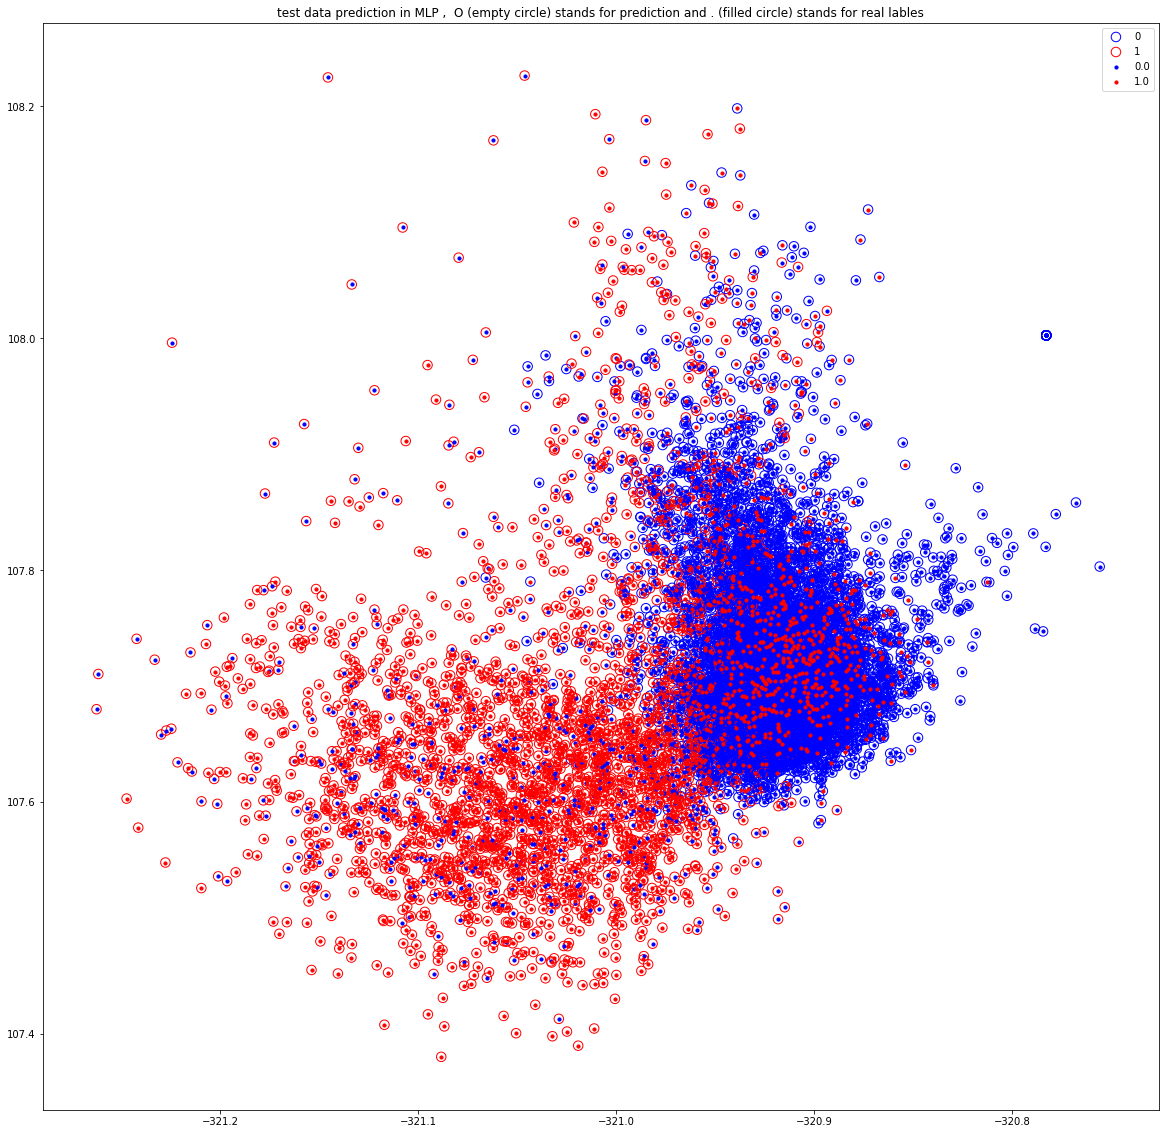

In [57]:
# TODO: visualize the output from the MLP on the test set (both probability and predicted label) and compare with the target label
test_L_MLP=1*(test_L_MLP>0.5)
data = pd.DataFrame({"X Value": rdTst[:, 0], "Y Value": rdTst[:, 1], "Category":test_L_MLP , "rel_L": test_label})
groups = data.groupby("Category")
plt.figure(figsize=(20,20))
for name, group in groups:
    if name==1:
        mycolor='r'
    else:
        mycolor='b'

    plt.scatter(group["X Value"], group["Y Value"],facecolors='none', edgecolors=mycolor, s=90, label=name)
plt.legend()

groups = data.groupby("rel_L")
for name, group in groups:
    if name==1:
        mycolor='r'
    else:
        mycolor='b'

    plt.scatter(group["X Value"], group["Y Value"],facecolors=mycolor, edgecolors=mycolor, s=10, label=name)
plt.legend()
plt.title( 'test data prediction in MLP ,  O (empty circle) stands for prediction and . (filled circle) stands for real lables')

    


plt.show()


Now you have a linear-SVM classifier and nonlinear MLP classifier. What are the pros and cons of them? 

In [59]:
# TODO: enter your observations here
# SVM takes less time, less calculation, training is easier and gets the same resullt everytime, 
# might not be able to predict complex relationships in the data.
#overfitting is not as big of a problem.

# MLP it can achieve better results and be more accurate, Predicts more than 2 classes of data, easier for nonlinearity. 



## 3: Post-processing

Until now, we are directly using the model predictions as the predicted labels for speech and non-speech regions. There are many ways that we can improve the results, and here we will try one of the post-processing methods - **smoothing**.

Smoothing is based on a straightforward intuition: if a frame is non-speech, then it is highly probably that its neighbouring frames are also non-speech. We can thus apply a local smoothing on the model predictions via moving average - the smoothed output at each frame is the average prediction output of its neighbouring frames.

Let's implement the smoothing strategy for both Linear-SVM outputs and MLP outputs. Here let's set the number of neighbouring frames to 7 - 3 in the past, 1 at the current frame, and 3 in the future. For the first 3 and last 3 frames where the number of past or future frames are not enough, we keep them unchanged.

In [74]:
# TODO: smoothing for Linear-SVM output label, print the accuracy
len_T=len(tst_pred)
test_L_MLP=outputT.cpu().detach().numpy()
smoothed_svm=[idx if idd <3 or idd>len_T-4 else (np.mean(tst_pred[idd-3:idd+4])>0.5)*1 for idd, idx in enumerate(tst_pred) ]
smoothed_MLP=[1*(idx>0.5) if idd <3 or idd>len_T-4 else (np.mean(test_L_MLP[idd-3:idd+4])>0.5)*1 for idd, idx in enumerate(test_L_MLP) ]

#Calculating the accs

ACC_smth_svm=np.mean(smoothed_svm==test_label)*100
ACC_smth_MLP=np.mean(smoothed_MLP==test_label)*100
print('Acc smoothed svm:',ACC_smth_svm)
print('Acc smoothed MLP on prob:',ACC_smth_MLP )


Acc smoothed svm: 86.7
Acc smoothed MLP on prob: 87.69


In [75]:
# TODO: smoothing for MLP output label, print the accuracy
test_L_MLP2=1*(outputT.cpu().detach().numpy()>0.5)
smoothed_MLP=[1*(idx>0.5) if idd <3 or idd>len_T-4 else (np.mean(test_L_MLP2[idd-3:idd+4])>0.5)*1 for idd, idx in enumerate(test_L_MLP2) ]
ACC_smth_MLP=np.mean(smoothed_MLP==test_label)*100
print('Acc smoothed MLP on label:',ACC_smth_MLP )

Acc smoothed MLP on label: 87.08


Visualize the MLP probabilities after smoothing, compare with the original probabilities. What do you find?

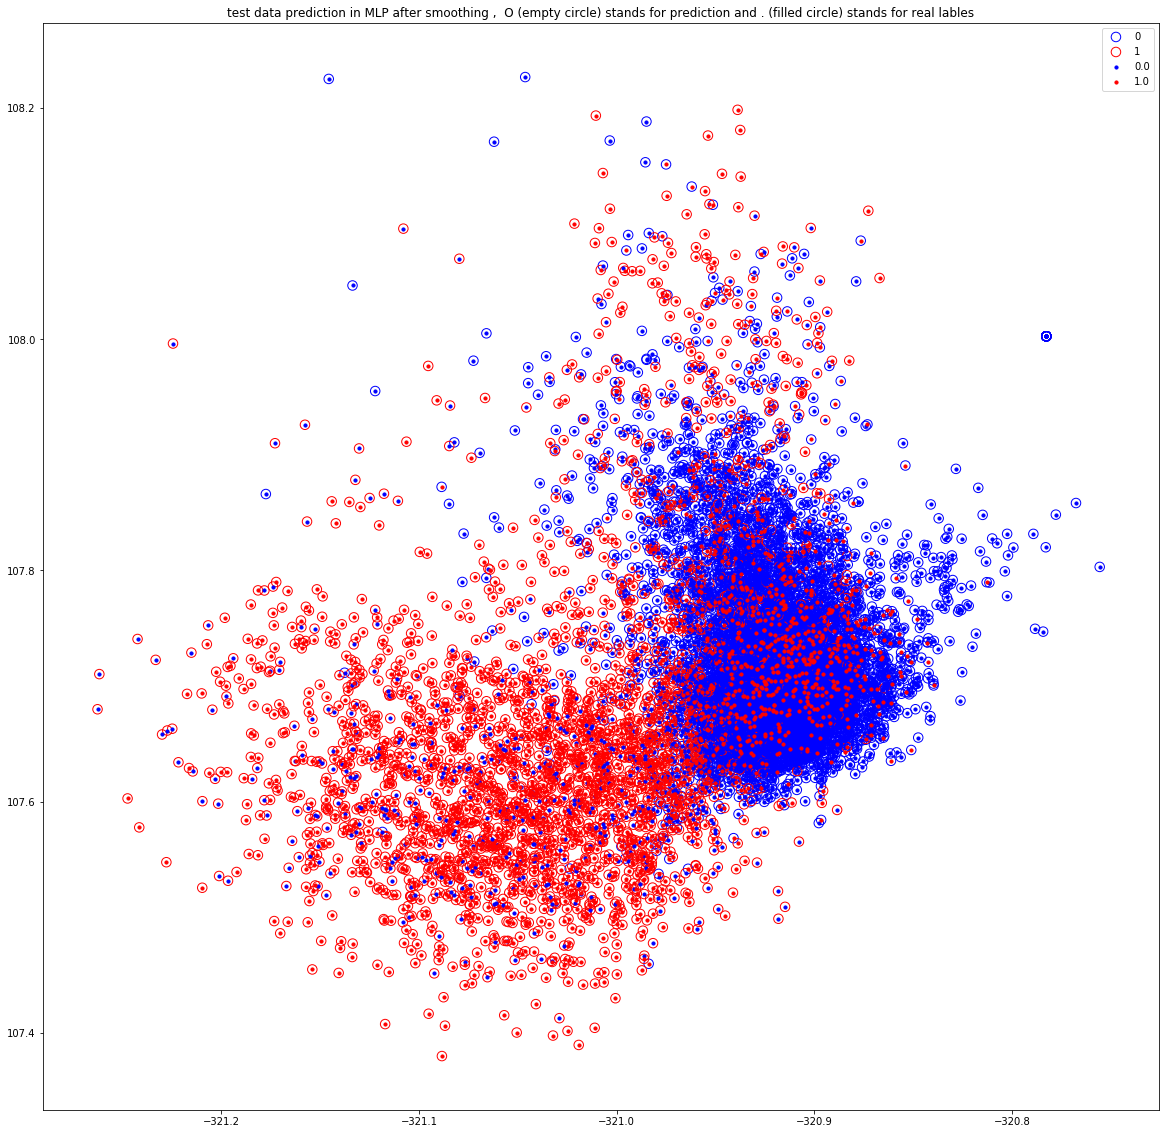

In [78]:
# TODO: visualization of predicted labels after smoothing the MLP output probabilities
smoothed_MLP=[1*(idx>0.5) if idd <3 or idd>len_T-4 else (np.mean(test_L_MLP[idd-3:idd+4])>0.5)*1 for idd, idx in enumerate(test_L_MLP) ]
data = pd.DataFrame({"X Value": rdTst[:, 0], "Y Value": rdTst[:, 1], "Category":smoothed_MLP , "rel_L": test_label})
groups = data.groupby("Category")
plt.figure(figsize=(20,20))
for name, group in groups:
    if name==1:
        mycolor='r'
    else:
        mycolor='b'

    plt.scatter(group["X Value"], group["Y Value"],facecolors='none', edgecolors=mycolor, s=90, label=name)
plt.legend()

groups = data.groupby("rel_L")
for name, group in groups:
    if name==1:
        mycolor='r'
    else:
        mycolor='b'

    plt.scatter(group["X Value"], group["Y Value"],facecolors=mycolor, edgecolors=mycolor, s=10, label=name)
plt.legend()
plt.title( 'test data prediction in MLP after smoothing ,  O (empty circle) stands for prediction and . (filled circle) stands for real lables')

    


plt.show()


In [79]:
# TODO: enter your discussions here

#After smoothing the accuracy increases overall, In Case of MLP smoothing on probabilities rather than labels gives
#better results which makes sense considering the fact that when we turn probabilities to labels we loose some information about
#the confidance of prediction for each frame.

## Discussion: Evaluation Metrics for VAD

We only used the classification accuracy as the evaluation metric for the systems above. However, there are well-defined evaluation metris for VAD task. The evaluation metrics for VAD systems is typically done by the following 4 metrics [(Beritelli, F., et al., 2002)](https://ieeexplore.ieee.org/abstract/document/995824/):
  -  **Front End Clipping (FEC)**: Clipping introduced in passing from noise to speech activity.
  -  **Mid Speech Clipping (MSC)**: Clipping due to speech misclassified as noise.
  -  **OVER**: Noise interpreted as speech due to the VAD flag remaining active in passing from speech activity to noise.
  -  **Noise Detected as Speech (NDS)**: Noise interpreted as
speech within a silence period.

The metrics can be visualized as follows. The image is adopted from https://github.com/jtkim-kaist/VAD.
<img src="https://user-images.githubusercontent.com/24668469/49742392-cd778680-fcdb-11e8-96b9-a599a4f85f4f.PNG">

If you are interested, you can try to implement the four metrics and evaluate the three models above with them. This is not part of the required excercises in this mini-project.

## Discussion: Input to the Models

We only used frame-level feature in the two models we built above. However, temporal information can be very important in audio processing tasks. There are several ways you can utilize the temporal information:
  -  Use **context of features**: instead of using the feature of the current frame, concatenate the features in the neighbouring frames to the current frame to create a **context**.
  -  Use **recurrent neural networks**: similar to the example we have in the Neural Network Basics homework.
  
You can play with different types of input features and compare the performance. This is not part of the required excercises in this mini-project.